In [ ]:
"""libraries required"""
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install timm
!pip install torchattacks

In [ ]:
"""connect to google drive to store and retrieve data"""
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import torch
import torch.nn.functional as F
import timm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def compute_distance(model, x, y, epsilon=0.005, num_steps=100):
    model = model.to(device)
    x = x.detach().clone().unsqueeze(0).to(device)  # We don't want to modify the original data
    x.requires_grad = True

    # Compute the v
    output = model(x)
    loss = F.cross_entropy(output, y.unsqueeze(0))
    model.zero_grad()
    loss.backward()
    v = x.grad / x.grad.norm()  # This is the normalized vector v
    # Now find the minimum epsilon such that model(x + epsilon * v) != y
    for _ in range(num_steps):
        x_adv = x + epsilon * v
        output = model(x_adv)
        if output.argmax(dim=1).squeeze(0).item() != y:
            break
        epsilon *= 1.1  # Increase epsilon

    return epsilon


def compute_avg_distance(models, dataset, indices):
    t_r18_r50 = 0
    t_r18_v = 0
    t_r18_m = 0
    t_r50_v = 0
    t_r50_m = 0
    t_m_v = 0
    for i in indices:
        x, y = dataset[i][0].to(device), dataset[i][1].to(device)
        r18 = compute_distance(models[0], x, y)
        r50 = compute_distance(models[1], x, y)
        v = compute_distance(models[2], x, y)
        m = compute_distance(models[3], x, y)

        t_r18_r50 += abs(r18 - r50)
        t_r18_v += abs(r18 - v)
        t_r18_m += abs(r18 - m)
        t_r50_v += abs(r50 - v)
        t_r50_m += abs(r50 - m)
        t_m_v += abs(v - m)

    print("r18 and r50: ", t_r18_r50 / len(indices))
    print("r18 and v: ", t_r18_v / len(indices))
    print("r18 and m: ", t_r18_m / len(indices))
    print("r50 and v: ", t_r50_v / len(indices))
    print("r50 and m: ", t_r50_m / len(indices))
    print("v and m: ", t_m_v / len(indices))

    return

In [39]:
from torch.utils.data import DataLoader, Subset
import timm
import torch.nn as nn

# Create a subset of the first 500 images
datasetName = 'ESC50'
out_feat=50

torch.cuda.empty_cache()

resnet18 = timm.create_model('resnet18.a1_in1k', pretrained=True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = nn.Linear(in_features=512, out_features=out_feat, bias=True)
checkpoint = torch.load(f'/content/drive/MyDrive/data/Models/{datasetName}/resnet18.pth')
resnet18.load_state_dict(checkpoint)

resnet50 = timm.create_model('resnet50.a1_in1k', pretrained=True)
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet50.fc = nn.Linear(in_features=2048, out_features=out_feat, bias=True)
checkpoint = torch.load(f'/content/drive/MyDrive/data/Models/{datasetName}/resnet50.pth')
resnet50.load_state_dict(checkpoint)

mixer = timm.create_model('mixer_b16_224.goog_in21k_ft_in1k', pretrained=True)
mixer.stem.proj = nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
mixer.head = nn.Linear(in_features=768, out_features=out_feat, bias=True)
checkpoint = torch.load(f'/content/drive/MyDrive/data/Models/{datasetName}/mixer.pth')
mixer.load_state_dict(checkpoint)

vit_base = timm.create_model('vit_base_patch16_224.augreg2_in21k_ft_in1k', pretrained=True)
vit_base.patch_embed.proj = nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
vit_base.head = nn.Linear(in_features=768, out_features=out_feat, bias=True)
checkpoint = torch.load(f'/content/drive/MyDrive/data/Models/{datasetName}/vit_base.pth')
vit_base.load_state_dict(checkpoint)

<All keys matched successfully>

In [34]:
import h5py
import torch
from torch.utils.data import TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

data_list = []
label_list = []

# Open the HDF5 file
h5_file_path = '/content/drive/MyDrive/data/AdvData/ESC50.h5'
with h5py.File(h5_file_path, 'r') as hf:
    # Iterate over the samples in the HDF5 file
    for sample_name in hf.keys():
        data = torch.tensor(hf[sample_name]['data'][:])
        label = hf[sample_name]['label'][()]

        # Append data and label to lists
        data_list.append(data)
        label_list.append(label)

esc = TensorDataset(torch.stack(data_list), torch.tensor(label_list))

In [ ]:
def get_correctly_classified_images(dataset, models):
    correct_images = []
    for i in range(len(dataset)):
        image = dataset[i][0].to(device)
        label = dataset[i][1].to(device)

        flag = 0
        for model in models:
            model.eval()
            prediction = model(image.unsqueeze(0)).argmax(dim=1).item()
            if (prediction != label):
                flag = 1
                break

        if (flag == 0): #correct by all models
            correct_images.append(i)
    print(correct_images)

In [ ]:
models = [resnet18.to(device), resnet50.to(device), vit_base.to(device), mixer.to(device)]
get_correctly_classified_images(esc, models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 22, 25, 26, 27, 28, 29, 31, 32, 34, 38, 40, 42, 43, 44, 47, 48, 49, 51, 52, 53, 54, 55, 56, 59, 60, 63, 65, 66, 67, 69, 70, 71, 75, 80, 81, 82, 85, 86, 88, 91, 93, 95, 97, 99, 101, 103, 104, 107, 108, 109, 110, 113, 114, 115, 116, 118, 120, 121, 123, 124, 125, 128, 129, 131, 132, 134, 135, 137, 138, 141, 142, 143, 145, 149, 150, 151, 152, 153, 154, 155, 156, 158, 159, 160, 163, 164, 165, 166, 169, 170, 172, 173, 175, 176, 178, 180, 182, 184, 185, 186, 187, 192, 193, 195, 196, 197, 198, 199, 200, 202, 203, 204, 206, 208, 210, 212, 213, 214, 215, 218, 219, 220, 221, 222, 223, 224, 225, 231, 234, 235, 238, 239, 240, 242, 243, 244, 245, 246, 248, 250, 251, 252, 253, 254, 255, 256, 257, 259, 263, 265, 266, 267, 268, 270, 271, 272, 274, 277, 278, 280, 281, 282, 286, 287, 288, 289, 290, 291, 292, 294, 295, 298, 300, 301, 302, 303, 304, 305, 306, 308, 309, 311, 312, 313, 314, 315, 316, 317, 318, 319, 321, 323, 324, 327, 328, 329, 330,

In [ ]:
import random
indices = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 22, 25, 26, 27, 28, 29, 31, 32, 34, 38, 40, 42, 43, 44, 47, 48, 49, 51, 52, 53, 54, 55, 56, 59, 60, 63, 65, 66, 67, 69, 70, 71, 75, 80, 81, 82, 85, 86, 88, 91, 93, 95, 97, 99, 101, 103, 104, 107, 108, 109, 110, 113, 114, 115, 116, 118, 120, 121, 123, 124, 125, 128, 129, 131, 132, 134, 135, 137, 138, 141, 142, 143, 145, 149, 150, 151, 152, 153, 154, 155, 156, 158, 159, 160, 163, 164, 165, 166, 169, 170, 172, 173, 175, 176, 178, 180, 182, 184, 185, 186, 187, 192, 193, 195, 196, 197, 198, 199, 200, 202, 203, 204, 206, 208, 210, 212, 213, 214, 215, 218, 219, 220, 221, 222, 223, 224, 225, 231, 234, 235, 238, 239, 240, 242, 243, 244, 245, 246, 248, 250, 251, 252, 253, 254, 255, 256, 257, 259, 263, 265, 266, 267, 268, 270, 271, 272, 274, 277, 278, 280, 281, 282, 286, 287, 288, 289, 290, 291, 292, 294, 295, 298, 300, 301, 302, 303, 304, 305, 306, 308, 309, 311, 312, 313, 314, 315, 316, 317, 318, 319, 321, 323, 324, 327, 328, 329, 330, 333, 334, 336, 337, 338, 339, 340, 341, 342, 343, 345, 346, 347, 349, 350, 351, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 377, 378, 379, 380, 381, 382, 383, 384, 387, 390, 391, 393, 394, 395, 396, 397, 398, 400, 401, 402, 405, 406, 407, 408, 410, 411, 412, 413, 414, 415, 418, 419, 420, 421, 423, 424, 427, 429, 431, 432, 433, 435, 436, 439, 440, 441, 443, 444, 445, 447, 448, 449, 450, 453, 454, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 470, 471, 472, 474, 475, 476, 478, 479, 482, 484, 485, 486, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 507, 509, 511, 512, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 535, 536, 538, 540, 541, 542, 543, 544, 547, 550, 551, 553, 554, 555, 556, 557, 558, 559, 560, 563, 564, 566, 568, 570, 571, 572, 575, 576, 580, 581, 583, 584, 585, 586, 587, 588, 589, 591, 594, 595, 596, 598, 599, 600, 601, 602, 603, 604, 607, 608, 609, 611, 612, 613, 615, 617, 618, 622, 623, 624, 626, 627, 628, 629, 630, 631, 632, 634, 638, 640, 641, 643, 644, 645, 646, 647, 651, 652, 653, 654, 657, 658, 659, 660, 661, 662, 663, 664, 666, 667, 668, 669, 672, 674, 676, 678, 679, 680, 681, 682, 684, 685, 686, 688, 689, 693, 694, 695, 696, 697, 698, 700, 701, 702, 703, 704, 706, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 723, 724, 725, 728, 729, 730, 731, 732, 733, 734, 735, 737, 738, 739, 741, 743, 744, 745, 746, 748, 750, 754, 756, 757, 758, 762, 765, 766, 767, 768, 770, 771, 772, 773, 774, 776, 777, 779, 780, 781, 782, 783, 784, 788, 789, 791, 792, 793, 794, 795, 797, 798, 799, 800, 802, 804, 805, 807, 808, 809, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 824, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 841, 842, 843, 844, 847, 848, 849, 851, 852, 853, 856, 858, 860, 862, 863, 865, 868, 869, 870, 871, 872, 873, 874, 875, 879, 881, 882, 884, 886, 889, 890, 891, 892, 893, 894, 895, 897, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 918, 919, 920, 922, 923, 924, 926, 927, 928, 929, 930, 932, 934, 935, 936, 938, 939, 940, 941, 942, 943, 944, 945, 947, 948, 950, 952, 953, 954, 955, 956, 962, 963, 964, 965, 969, 970, 971, 973, 974, 975, 976, 977, 980, 981, 982, 983, 984, 988, 989, 990, 991, 994, 995, 996, 997, 998, 999, 1000, 1001, 1009, 1012, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1033, 1034, 1035, 1036, 1038, 1040, 1043, 1044, 1046, 1048, 1049, 1051, 1052, 1054, 1055, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1070, 1071, 1075, 1076, 1077, 1078, 1079, 1082, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1096, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1106, 1109, 1110, 1112, 1114, 1115, 1116, 1117, 1118, 1120, 1122, 1123, 1124, 1125, 1126, 1128, 1129, 1130, 1132, 1133, 1134, 1137, 1138, 1142, 1143, 1145, 1146, 1147, 1148, 1151, 1153, 1154, 1156, 1159, 1160, 1161, 1162, 1163, 1164, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1181, 1182, 1183, 1184, 1185, 1188, 1189, 1190, 1191, 1192, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1202, 1203, 1204, 1205, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1221, 1222, 1223, 1225, 1226, 1227, 1229, 1232, 1234, 1235, 1236, 1240, 1243, 1244, 1245, 1246, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1257, 1258, 1260, 1261, 1265, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1280, 1282, 1283, 1284, 1285, 1286, 1290, 1292, 1293, 1294, 1295, 1296, 1300, 1301, 1302, 1304, 1305, 1307, 1308, 1309, 1311, 1312, 1313, 1315, 1318, 1319, 1320, 1321, 1322, 1324, 1325, 1326, 1327, 1329, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1372, 1373, 1374, 1375, 1376, 1378, 1379, 1380, 1385, 1386, 1388, 1389, 1391, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1438, 1442, 1445, 1447, 1451, 1452, 1454, 1455, 1457, 1458, 1459, 1460, 1462, 1468, 1470, 1471, 1472, 1473, 1474, 1478, 1483, 1484, 1485, 1487, 1488, 1489, 1490, 1493, 1495, 1496, 1498, 1499, 1500, 1502, 1505, 1508, 1509, 1510, 1512, 1514, 1515, 1516, 1517, 1518, 1519, 1521, 1522, 1524, 1525, 1526, 1527, 1529, 1530, 1532, 1533, 1535, 1536, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1550, 1551, 1552, 1553, 1554, 1556, 1558, 1559, 1561, 1563, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1577, 1578, 1579, 1580, 1582, 1583, 1584, 1585, 1586, 1587, 1589, 1591, 1593, 1594, 1595, 1596, 1598, 1599, 1601, 1604, 1606, 1608, 1613, 1614, 1616, 1617, 1623, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1640, 1641, 1643, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1653, 1655, 1656, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1685, 1686, 1688, 1689, 1691, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1702, 1705, 1707, 1708, 1712, 1713, 1715, 1716, 1720, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1730, 1732, 1733, 1735, 1736, 1738, 1740, 1742, 1746, 1749, 1750, 1753, 1755, 1757, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1771, 1773, 1774, 1775, 1776, 1777, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1792, 1793, 1795, 1796, 1797, 1798, 1799, 1800, 1802, 1804, 1806, 1808, 1809, 1810, 1813, 1814, 1815, 1816, 1818, 1819, 1820, 1822, 1825, 1826, 1827, 1828, 1830, 1831, 1832, 1833, 1835, 1836, 1841, 1842, 1844, 1845, 1846, 1847, 1848, 1849, 1852, 1853, 1854, 1856, 1857, 1858, 1859, 1860, 1862, 1863, 1864, 1865, 1867, 1868, 1869, 1871, 1874, 1875, 1877, 1878, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1895, 1896, 1898, 1900, 1901, 1904, 1907, 1908, 1909, 1910, 1912, 1914, 1916, 1917, 1919, 1920, 1921, 1922, 1926, 1927, 1928, 1929, 1934, 1935, 1936, 1938, 1939, 1942, 1944, 1945, 1946, 1949, 1951, 1952, 1953, 1954, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1986, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998]
indices_esc = random.sample(indices, 600)

In [ ]:
models = [resnet18.to(device), resnet50.to(device), vit_base.to(device), mixer.to(device)]
compute_avg_distance(models, esc, indices_esc)
# 0...600

r18 and r50:  0.16220760830262632
r18 and v:  2.3698230578923933
r18 and m:  1.879877746100089
r50 and v:  2.2159374577271094
r50 and m:  1.7297940037259416
v and m:  2.2976757712272593


# FSC22

In [ ]:
import h5py
import torch
from torch.utils.data import TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

data_list = []
label_list = []

# Open the HDF5 file
h5_file_path = '/content/drive/MyDrive/data/AdvData/FSC22.h5'
with h5py.File(h5_file_path, 'r') as hf:
    # Iterate over the samples in the HDF5 file
    for sample_name in hf.keys():
        data = torch.tensor(hf[sample_name]['data'][:])
        label = hf[sample_name]['label'][()]

        # Append data and label to lists
        data_list.append(data)
        label_list.append(label)

fsc = TensorDataset(torch.stack(data_list), torch.tensor(label_list))

In [ ]:
models = [resnet18.to(device), resnet50.to(device), vit_base.to(device), mixer.to(device)]
get_correctly_classified_images(fsc, models)

[1, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 18, 21, 22, 23, 24, 27, 29, 30, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 52, 54, 56, 58, 59, 60, 61, 63, 64, 65, 68, 70, 71, 73, 74, 75, 76, 77, 79, 81, 82, 84, 85, 89, 90, 93, 94, 95, 96, 99, 101, 102, 103, 105, 106, 108, 109, 110, 111, 113, 114, 115, 119, 120, 121, 122, 123, 124, 126, 127, 129, 130, 131, 133, 136, 137, 138, 140, 141, 142, 147, 148, 157, 158, 165, 168, 169, 170, 173, 175, 176, 178, 179, 180, 184, 185, 188, 189, 190, 191, 195, 197, 198, 199, 200, 201, 203, 205, 206, 207, 208, 218, 221, 222, 226, 228, 230, 232, 235, 237, 239, 240, 241, 242, 243, 244, 246, 248, 250, 251, 253, 254, 255, 256, 257, 259, 260, 261, 262, 265, 266, 267, 268, 270, 271, 272, 273, 274, 276, 277, 278, 279, 280, 282, 283, 284, 285, 286, 287, 288, 289, 292, 293, 294, 296, 297, 299, 300, 301, 302, 303, 304, 305, 306, 307, 310, 315, 319, 322, 325, 326, 327, 328, 329, 331, 332, 333, 334, 336, 337, 338, 339, 340, 341, 342, 343, 345, 347, 348, 349

In [ ]:
import random
indices_fsc = [1, 4, 6, 7, 9, 10, 11, 12, 13, 14, 15, 18, 21, 22, 23, 24, 27, 29, 30, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 52, 54, 56, 58, 59, 60, 61, 63, 64, 65, 68, 70, 71, 73, 74, 75, 76, 77, 79, 81, 82, 84, 85, 89, 90, 93, 94, 95, 96, 99, 101, 102, 103, 105, 106, 108, 109, 110, 111, 113, 114, 115, 119, 120, 121, 122, 123, 124, 126, 127, 129, 130, 131, 133, 136, 137, 138, 140, 141, 142, 147, 148, 157, 158, 165, 168, 169, 170, 173, 175, 176, 178, 179, 180, 184, 185, 188, 189, 190, 191, 195, 197, 198, 199, 200, 201, 203, 205, 206, 207, 208, 218, 221, 222, 226, 228, 230, 232, 235, 237, 239, 240, 241, 242, 243, 244, 246, 248, 250, 251, 253, 254, 255, 256, 257, 259, 260, 261, 262, 265, 266, 267, 268, 270, 271, 272, 273, 274, 276, 277, 278, 279, 280, 282, 283, 284, 285, 286, 287, 288, 289, 292, 293, 294, 296, 297, 299, 300, 301, 302, 303, 304, 305, 306, 307, 310, 315, 319, 322, 325, 326, 327, 328, 329, 331, 332, 333, 334, 336, 337, 338, 339, 340, 341, 342, 343, 345, 347, 348, 349, 350, 355, 357, 358, 362, 364, 365, 366, 367, 370, 371, 372, 375, 376, 382, 385, 386, 388, 389, 390, 392, 393, 396, 397, 398, 399, 400, 402, 407, 409, 410, 413, 414, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 440, 441, 443, 444, 445, 446, 448, 452, 453, 454, 455, 461, 462, 466, 468, 472, 474, 475, 476, 478, 479, 481, 483, 487, 488, 490, 491, 492, 493, 494, 495, 498, 499, 503, 504, 506, 507, 508, 509, 510, 511, 512, 514, 515, 517, 518, 521, 522, 528, 529, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 545, 547, 548, 549, 550, 553, 557, 558, 560, 561, 565, 566, 567, 569, 571, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 599, 601, 602, 603, 605, 606, 608, 610, 613, 616, 617, 619, 620, 621, 622, 623, 624, 625, 628, 630, 632, 633, 635, 637, 638, 639, 641, 642, 645, 647, 648, 650, 651, 652, 654, 655, 657, 660, 661, 663, 665, 666, 667, 668, 669, 670, 671, 672, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 687, 688, 689, 691, 695, 697, 699, 702, 704, 705, 706, 707, 708, 709, 711, 713, 714, 716, 717, 718, 719, 720, 725, 727, 730, 732, 733, 734, 735, 736, 737, 739, 740, 741, 742, 745, 748, 751, 752, 755, 757, 760, 765, 766, 767, 768, 770, 771, 773, 775, 776, 777, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 790, 791, 793, 795, 801, 804, 805, 806, 807, 808, 809, 811, 815, 818, 820, 821, 822, 824, 825, 827, 829, 830, 831, 832, 837, 838, 840, 846, 850, 853, 855, 857, 858, 860, 862, 863, 864, 865, 866, 867, 872, 873, 874, 876, 879, 881, 882, 884, 885, 889, 890, 891, 893, 895, 897, 898, 899, 900, 901, 902, 906, 907, 908, 912, 913, 914, 915, 919, 921, 923, 926, 927, 928, 929, 930, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 948, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 966, 968, 969, 971, 972, 973, 974, 975, 976, 978, 979, 980, 981, 983, 984, 988, 989, 990, 991, 992, 994, 995, 996, 997, 998, 999, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1028, 1029, 1032, 1033, 1034, 1035, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1055, 1057, 1058, 1059, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1076, 1077, 1078, 1079, 1081, 1082, 1083, 1084, 1085, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1098, 1101, 1102, 1103, 1104, 1106, 1110, 1111, 1112, 1113, 1114, 1118, 1123, 1125, 1129, 1136, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1158, 1159, 1160, 1161, 1163, 1165, 1166, 1168, 1171, 1175, 1179, 1180, 1182, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1196, 1197, 1198, 1200, 1201, 1202, 1204, 1207, 1208, 1209, 1211, 1214, 1215, 1216, 1218, 1219, 1221, 1223, 1224, 1225, 1226, 1228, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1242, 1243, 1244, 1245, 1248, 1249, 1250, 1252, 1253, 1254, 1255, 1260, 1263, 1264, 1265, 1266, 1268, 1269, 1270, 1271, 1276, 1277, 1278, 1280, 1281, 1282, 1284, 1286, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1297, 1298, 1299, 1302, 1303, 1305, 1306, 1307, 1308, 1310, 1313, 1315, 1317, 1320, 1321, 1326, 1328, 1330, 1332, 1333, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1345, 1346, 1347, 1348, 1349, 1350, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1404, 1408, 1409, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1422, 1424, 1425, 1426, 1428, 1429, 1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440, 1441, 1443, 1444, 1445, 1446, 1448, 1449, 1450, 1451, 1453, 1455, 1456, 1459, 1460, 1462, 1463, 1465, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1485, 1486, 1490, 1491, 1492, 1493, 1494, 1496, 1497, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1513, 1514, 1515, 1516, 1520, 1521, 1522, 1524, 1525, 1528, 1529, 1530, 1533, 1537, 1538, 1539, 1540, 1541, 1542, 1544, 1545, 1547, 1548, 1551, 1556, 1559, 1560, 1561, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1572, 1574, 1575, 1576, 1579, 1580, 1581, 1582, 1586, 1587, 1588, 1593, 1599, 1601, 1602, 1603, 1604, 1605, 1606, 1611, 1612, 1614, 1616, 1618, 1620, 1625, 1627, 1628, 1633, 1634, 1636, 1637, 1638, 1639, 1641, 1643, 1644, 1647, 1650, 1652, 1661, 1665, 1666, 1669, 1672, 1675, 1676, 1677, 1678, 1682, 1684, 1685, 1686, 1690, 1692, 1693, 1696, 1697, 1702, 1705, 1706, 1707, 1710, 1711, 1712, 1720, 1721, 1722, 1724, 1725, 1730, 1731, 1732, 1735, 1736, 1739, 1740, 1744, 1746, 1748, 1750, 1751, 1752, 1753, 1754, 1756, 1761, 1763, 1766, 1769, 1771, 1772, 1774, 1775, 1777, 1778, 1779, 1780, 1781, 1782, 1784, 1786, 1787, 1788, 1793, 1794, 1795, 1796, 1799, 1800, 1805, 1808, 1813, 1814, 1815, 1816, 1817, 1819, 1820, 1826, 1827, 1828, 1832, 1834, 1837, 1839, 1845, 1853, 1854, 1856, 1858, 1860, 1863, 1867, 1868, 1873, 1874, 1877, 1879, 1887, 1888, 1890, 1891, 1898, 1899, 1902, 1906, 1913, 1915, 1916, 1917, 1918, 1919, 1921, 1922, 1923, 1924, 1925, 1928, 1931, 1933, 1934, 1935, 1937, 1942, 1943, 1944, 1945, 1946, 1947, 1951, 1953, 1954, 1957, 1958, 1959, 1962, 1963, 1964, 1965, 1966, 1968, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1982, 1984, 1985, 1986, 1987, 1988, 1990, 1991, 1994, 1995, 1997, 1999, 2002, 2003, 2004, 2005, 2006, 2007, 2009, 2010, 2011, 2012, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2024]
random_indices = random.sample(indices_fsc, 600)
# 600 of ~ 1200

In [ ]:
models = [resnet18.to(device), resnet50.to(device), vit_base.to(device), mixer.to(device)]
compute_avg_distance(models, fsc, random_indices)

r18 and r50:  1.1805610419089572
r18 and v:  4.006335188372429
r18 and m:  2.9286501496767468
r50 and v:  4.38508792141411
r50 and m:  3.211821492715452
v and m:  3.7982671330989857


# DCASE19

In [ ]:
import h5py
import torch
from torch.utils.data import TensorDataset

device = "cuda" if torch.cuda.is_available() else "cpu"

data_list = []
label_list = []

# Open the HDF5 file
h5_file_path = '/content/drive/MyDrive/data/AdvData/DCASE19.h5'
with h5py.File(h5_file_path, 'r') as hf:
    # Iterate over the samples in the HDF5 file
    for sample_name in hf.keys():
        data = torch.tensor(hf[sample_name]['data'][:])
        label = hf[sample_name]['label'][()]

        # Append data and label to lists
        data_list.append(data)
        label_list.append(label)

dcase = TensorDataset(torch.stack(data_list), torch.tensor(label_list))

In [ ]:
models = [resnet18.to(device), resnet50.to(device), vit_base.to(device), mixer.to(device)]
get_correctly_classified_images(dcase, models)

[1, 3, 5, 6, 7, 10, 12, 15, 17, 20, 26, 33, 34, 35, 36, 37, 44, 45, 48, 52, 56, 57, 59, 64, 69, 75, 81, 82, 83, 87, 90, 91, 92, 97, 99, 100, 101, 104, 108, 109, 111, 113, 114, 117, 123, 125, 127, 131, 151, 159, 162, 164, 166, 169, 172, 173, 174, 177, 180, 181, 182, 183, 184, 185, 186, 187, 190, 193, 194, 195, 197, 200, 204, 210, 217, 218, 224, 226, 238, 242, 248, 250, 251, 252, 257, 258, 259, 261, 262, 263, 265, 266, 267, 270, 271, 272, 274, 276, 277, 280, 281, 283, 287, 288, 289, 296, 297, 298, 299, 300, 305, 306, 307, 308, 309, 310, 311, 312, 313, 316, 317, 319, 320, 321, 322, 324, 326, 328, 330, 332, 333, 334, 335, 336, 337, 341, 345, 348, 350, 353, 357, 359, 362, 368, 382, 391, 392, 394, 397, 398, 402, 403, 408, 412, 413, 416, 420, 425, 428, 447, 448, 452, 458, 463, 466, 469, 473, 475, 477, 479, 480, 484, 485, 486, 488, 489, 493, 494, 496, 497, 498, 499, 500, 501, 502, 505, 506, 510, 513, 514, 515, 517, 518, 523, 525, 526, 531, 533, 534, 538, 540, 541, 542, 546, 548, 550, 551, 552,

In [ ]:
import random

indices_dcase = [1, 3, 5, 6, 7, 10, 12, 15, 17, 20, 26, 33, 34, 35, 36, 37, 44, 45, 48, 52, 56, 57, 59, 64, 69, 75, 81, 82, 83, 87, 90, 91, 92, 97, 99, 100, 101, 104, 108, 109, 111, 113, 114, 117, 123, 125, 127, 131, 151, 159, 162, 164, 166, 169, 172, 173, 174, 177, 180, 181, 182, 183, 184, 185, 186, 187, 190, 193, 194, 195, 197, 200, 204, 210, 217, 218, 224, 226, 238, 242, 248, 250, 251, 252, 257, 258, 259, 261, 262, 263, 265, 266, 267, 270, 271, 272, 274, 276, 277, 280, 281, 283, 287, 288, 289, 296, 297, 298, 299, 300, 305, 306, 307, 308, 309, 310, 311, 312, 313, 316, 317, 319, 320, 321, 322, 324, 326, 328, 330, 332, 333, 334, 335, 336, 337, 341, 345, 348, 350, 353, 357, 359, 362, 368, 382, 391, 392, 394, 397, 398, 402, 403, 408, 412, 413, 416, 420, 425, 428, 447, 448, 452, 458, 463, 466, 469, 473, 475, 477, 479, 480, 484, 485, 486, 488, 489, 493, 494, 496, 497, 498, 499, 500, 501, 502, 505, 506, 510, 513, 514, 515, 517, 518, 523, 525, 526, 531, 533, 534, 538, 540, 541, 542, 546, 548, 550, 551, 552, 554, 558, 559, 561, 562, 563, 568, 569, 570, 571, 573, 574, 575, 578, 579, 580, 581, 583, 584, 586, 587, 590, 591, 594, 595, 597, 598, 599, 600, 603, 605, 606, 608, 610, 611, 612, 613, 619, 620, 621, 622, 626, 627, 632, 633, 636, 638, 640, 641, 644, 645, 646, 648, 649, 650, 651, 652, 653, 656, 664, 665, 673, 674, 680, 681, 683, 684, 685, 687, 688, 690, 691, 692, 693, 694, 695, 697, 698, 699, 703, 704, 705, 708, 709, 710, 713, 714, 715, 720, 721, 723, 724, 728, 730, 731, 736, 737, 741, 743, 744, 746, 747, 749, 750, 751, 753, 759, 762, 765, 768, 770, 771, 772, 774, 775, 779, 783, 784, 785, 788, 789, 792, 793, 794, 799, 800, 801, 803, 806, 807, 808, 809, 812, 813, 816, 817, 819, 820, 821, 823, 824, 826, 827, 829, 830, 831, 832, 833, 837, 840, 841, 842, 844, 845, 846, 849, 850, 851, 852, 853, 854, 855, 856, 857, 859, 860, 862, 863, 864, 865, 866, 867, 870, 871, 872, 873, 874, 875, 876, 879, 880, 881, 882, 884, 885, 886, 888, 889, 890, 891, 892, 893, 894, 896, 898, 900, 901, 902, 903, 905, 910, 913, 914, 915, 916, 917, 919, 922, 923, 924, 925, 927, 928, 931, 932, 933, 936, 939, 943, 949, 950, 955, 958, 961, 964, 967, 969, 971, 975, 981, 982, 983, 985, 986, 988, 989, 991, 993, 995, 996, 997, 999, 1002, 1006, 1007, 1008, 1009, 1010, 1011, 1013, 1014, 1017, 1018, 1021, 1025, 1026, 1028, 1032, 1036, 1038, 1040, 1041, 1042, 1043, 1047, 1048, 1058, 1060, 1061, 1066, 1067, 1071, 1072, 1076, 1080, 1081, 1085, 1086, 1088, 1090, 1091, 1092, 1094, 1095, 1096, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1117, 1120, 1122, 1123, 1124, 1125, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1160, 1161, 1162, 1163, 1164, 1166, 1168, 1169, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1185, 1186, 1189, 1190, 1193, 1194, 1195, 1196, 1197, 1198, 1200, 1201, 1204, 1206, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1223, 1224, 1225, 1226, 1227, 1228, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1254, 1255, 1256, 1257, 1259, 1261, 1262, 1263, 1265, 1266, 1269, 1271, 1272, 1273, 1274, 1275, 1276, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1288, 1289, 1290, 1291, 1292, 1293, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1304, 1305, 1306, 1307, 1308, 1310, 1311, 1313, 1315, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1326, 1328, 1329, 1330, 1331, 1332, 1333, 1335, 1336, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1349, 1350, 1353, 1355, 1358, 1360, 1361, 1362, 1363, 1365, 1366, 1372, 1373, 1374, 1375, 1376, 1378, 1379, 1380, 1382, 1383, 1385, 1386, 1387, 1388, 1389, 1390, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1405, 1406, 1407, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1430, 1431, 1432, 1433, 1434, 1435, 1437, 1438, 1439, 1440, 1441, 1442, 1444, 1445, 1446, 1447, 1449, 1450, 1451, 1452, 1453, 1454, 1456, 1457, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1471, 1472, 1473, 1474, 1476, 1477, 1478, 1479, 1480, 1482, 1485, 1486, 1487, 1488, 1489, 1491, 1492, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1507, 1508, 1509, 1510, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1574, 1578, 1579, 1580, 1581, 1582, 1584, 1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1601, 1602, 1604, 1605, 1606, 1607, 1608, 1611, 1612, 1614, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1632, 1633, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1654, 1657, 1658, 1661, 1662, 1665, 1668, 1669, 1671, 1672, 1673, 1675, 1676, 1677, 1679, 1680, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1704, 1705, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1735, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1780, 1782, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791, 1793, 1795, 1796, 1797, 1798, 1799, 1800, 1801, 1802, 1804, 1805, 1806, 1807, 1808, 1809, 1811, 1812, 1813, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890, 1891, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1902, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1913, 1915, 1916, 1917, 1918, 1919, 1920, 1922, 1923, 1924, 1927, 1928, 1931, 1932, 1934, 1935, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2036, 2037, 2038, 2039, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2081, 2082, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2111, 2112, 2113, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2175, 2176, 2177, 2178, 2179, 2181, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2192, 2196, 2197, 2200, 2201, 2202, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211, 2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223, 2225, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2249, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2260, 2261, 2262, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2373, 2374, 2376, 2377, 2378, 2379, 2380, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2404, 2405, 2406, 2407, 2409, 2410, 2411, 2412, 2413, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2448, 2449, 2451, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2463, 2466, 2467, 2468, 2469, 2470, 2473, 2475, 2476, 2478, 2480, 2481, 2484, 2485, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2494, 2495, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2508, 2510, 2511, 2513, 2514, 2515, 2516, 2518, 2520, 2521, 2522, 2523, 2527, 2529, 2531, 2532, 2533, 2534, 2536, 2537, 2540, 2541, 2542, 2543, 2546, 2547, 2548, 2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2575, 2577, 2578, 2579, 2580, 2582, 2584, 2585, 2587, 2588, 2589, 2590, 2591, 2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2624, 2626, 2627, 2628, 2629, 2630, 2631, 2633, 2635, 2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2648, 2649, 2650, 2652, 2653, 2654, 2655, 2657, 2658, 2659, 2660, 2661, 2662, 2665, 2666, 2669, 2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680, 2683, 2685, 2686, 2687, 2688, 2689, 2690, 2692, 2694, 2697, 2699, 2700, 2703, 2710, 2711, 2712, 2716, 2717, 2719, 2721, 2722, 2725, 2726, 2731, 2732, 2734, 2737, 2741, 2743, 2745, 2746, 2748, 2749, 2750, 2757, 2758, 2766, 2767, 2770, 2771, 2772, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2785, 2788, 2790, 2792, 2795, 2796, 2798, 2799, 2800, 2802, 2803, 2806, 2807, 2810, 2811, 2813, 2815, 2817, 2818, 2822, 2823, 2824, 2826, 2827, 2828, 2829, 2830, 2832, 2833, 2836, 2837, 2838, 2840, 2848, 2849, 2850, 2851, 2853, 2854, 2855, 2856, 2857, 2860, 2861, 2865, 2866, 2867, 2869, 2872, 2874, 2876, 2878, 2880, 2881, 2886, 2887, 2889, 2891, 2892, 2895, 2902, 2904, 2905, 2908, 2910, 2911, 2913, 2916, 2917, 2918, 2920, 2921, 2922, 2923, 2926, 2931, 2933, 2940, 2942, 2943, 2944, 2945, 2947, 2951, 2954, 2957, 2958, 2960, 2962, 2963, 2964, 2965, 2966, 2968, 2969, 2972, 2973, 2976, 2977, 2978, 2981, 2983, 2985, 2987, 2990, 2991, 2992, 2993, 3002, 3004, 3009, 3011, 3013, 3014, 3015, 3019, 3020, 3023, 3026, 3029, 3030, 3031, 3032, 3033, 3038, 3039, 3040, 3043, 3045, 3046, 3047, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3060, 3061, 3062, 3066, 3069, 3079, 3081, 3083, 3088, 3090, 3092, 3093, 3094, 3096, 3097, 3099, 3100, 3101, 3102, 3103, 3104, 3106, 3107, 3108, 3110, 3111, 3112, 3113, 3114, 3116, 3117, 3118, 3120, 3121, 3122, 3124, 3126, 3129, 3130, 3131, 3132, 3134, 3135, 3136, 3137, 3139, 3140, 3141, 3147, 3150, 3152, 3153, 3155, 3156, 3157, 3158, 3160, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3172, 3173, 3174, 3176, 3180, 3181, 3183, 3184, 3185, 3186, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3206, 3210, 3213, 3217, 3219, 3223, 3224, 3226, 3228, 3229, 3230, 3231, 3232, 3233, 3235, 3236, 3238, 3241, 3242, 3244, 3245, 3246, 3247, 3250, 3251, 3252, 3253, 3254, 3258, 3259, 3260, 3261, 3262, 3263, 3264, 3266, 3267, 3268, 3271, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3282, 3283, 3284, 3286, 3292, 3293, 3294, 3300, 3301, 3302, 3304, 3306, 3307, 3312, 3313, 3315, 3316, 3317, 3319, 3320, 3324, 3325, 3328, 3330, 3331, 3332, 3333, 3335, 3337, 3338, 3339, 3340, 3342, 3344, 3348, 3351, 3357, 3359, 3360, 3362, 3364, 3367, 3369, 3370, 3371, 3373, 3374, 3375, 3378, 3379, 3380, 3382, 3383, 3384, 3385, 3386, 3387, 3389, 3391, 3392, 3393, 3397, 3398, 3399, 3400, 3401, 3402, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3411, 3412, 3413, 3415, 3416, 3417, 3420, 3421, 3422, 3423, 3426, 3428, 3429, 3430, 3431, 3432, 3434, 3435, 3437, 3438, 3439, 3442, 3443, 3444, 3445, 3446, 3447, 3448, 3449, 3450, 3452, 3453, 3454, 3457, 3458, 3459, 3460, 3461, 3462, 3465, 3468, 3469, 3470, 3471, 3472, 3474, 3475, 3476, 3479, 3482, 3484, 3486, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3494, 3495, 3496, 3498, 3500, 3501, 3503, 3504, 3506, 3511, 3512, 3521, 3524, 3525, 3534, 3538, 3542, 3547, 3550, 3552, 3553, 3557, 3558, 3559, 3560, 3561, 3562, 3564, 3568, 3569, 3570, 3572, 3574, 3575, 3577, 3578, 3580, 3581, 3582, 3584, 3586, 3587, 3588, 3589, 3590, 3592, 3594, 3595, 3597, 3598, 3600, 3601, 3602, 3603, 3605, 3606, 3607, 3609, 3610, 3611, 3612, 3613, 3615, 3617, 3620, 3624, 3625, 3630, 3631, 3632, 3633, 3634, 3636, 3637, 3638, 3643, 3644, 3645, 3646, 3647, 3648, 3649, 3652, 3653, 3654, 3655, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3671, 3672, 3673, 3674, 3675, 3676, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3687, 3688, 3689, 3690, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3699, 3700, 3702, 3703, 3705, 3706, 3707, 3709, 3710, 3711, 3713, 3716, 3717, 3720, 3722, 3724, 3725, 3726, 3728, 3729, 3730, 3733, 3734, 3735, 3736, 3737, 3739, 3741, 3743, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3757, 3759, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3770, 3772, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3786, 3790, 3792, 3794, 3795, 3797, 3799, 3801, 3802, 3803, 3804, 3806, 3807, 3808, 3809, 3811, 3815, 3817, 3818, 3819, 3820, 3823, 3825, 3826, 3830, 3834, 3836, 3837, 3838, 3847, 3850, 3852, 3856, 3857, 3858, 3861, 3862, 3863, 3865, 3867, 3869, 3872, 3873, 3876, 3877, 3879, 3880, 3881, 3882, 3884, 3887, 3888, 3892, 3893, 3900, 3901, 3903, 3905, 3907, 3908, 3911, 3913, 3917, 3919, 3922, 3927, 3930, 3932, 3934, 3935, 3936, 3940, 3944, 3947, 3956, 3958, 3960, 3963, 3964, 3965, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3978, 3979, 3981, 3982, 3983, 3987, 3988, 3989, 3990, 3992, 3993, 3994, 3995, 3996, 3997, 3999, 4000, 4001, 4002, 4004, 4005, 4006, 4007, 4008, 4009, 4011, 4012, 4013, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4025, 4026, 4027, 4029, 4030, 4032, 4033, 4034, 4035, 4036, 4037, 4039, 4043, 4044, 4046, 4047, 4049, 4050, 4052, 4054, 4055, 4056, 4062, 4064, 4068, 4069, 4070, 4072, 4073, 4074, 4075, 4076, 4080, 4082, 4086, 4088, 4089, 4091, 4093, 4094, 4096, 4099, 4102, 4103, 4106, 4107, 4109, 4110, 4111, 4112, 4113, 4114, 4119, 4121, 4122, 4126, 4127, 4129, 4130, 4134, 4137, 4142, 4146, 4149, 4153, 4160, 4164, 4169, 4172, 4177, 4179, 4180, 4182, 4183, 4184, 4186, 4188, 4189, 4191, 4192, 4196, 4197, 4198, 4201, 4202, 4203, 4209, 4213, 4218, 4224, 4225, 4229, 4231, 4232, 4236, 4237, 4247, 4248, 4251, 4253, 4255, 4258, 4261, 4265, 4267, 4268, 4269, 4271, 4274, 4276, 4278, 4279, 4280, 4281, 4282, 4283, 4285, 4288, 4290, 4291, 4292, 4293, 4295, 4297, 4298, 4299, 4300, 4301, 4303, 4307, 4309, 4310, 4311, 4312, 4313, 4314, 4315, 4316, 4318, 4320, 4321, 4322, 4323, 4325, 4327, 4329, 4330, 4331, 4332, 4337, 4338, 4339, 4341, 4342, 4343, 4344, 4345, 4346, 4347, 4348, 4349, 4350, 4351, 4352, 4353, 4354, 4355, 4356, 4357, 4358, 4359, 4360, 4361, 4363, 4364, 4365, 4366, 4367, 4368, 4369, 4370, 4371, 4372, 4373, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4385, 4387, 4388, 4390, 4391, 4393, 4395, 4397, 4400, 4401, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4413, 4415, 4416, 4419, 4420, 4423, 4424, 4427, 4429, 4430, 4431, 4432, 4433, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4443, 4444, 4445, 4447, 4448, 4452, 4453, 4454, 4455, 4456, 4457, 4459, 4460, 4461, 4462, 4463, 4464, 4465, 4466, 4467, 4468, 4471, 4472, 4473, 4474, 4475, 4476, 4477, 4482, 4484, 4485, 4487, 4488, 4490, 4492, 4493, 4494, 4495, 4499, 4501, 4502, 4503, 4506, 4508, 4510, 4511, 4512, 4513, 4514, 4515, 4516, 4517, 4518, 4519, 4520, 4521, 4523, 4524, 4525, 4527, 4528, 4529, 4530, 4531, 4532, 4533, 4535, 4536, 4537, 4538, 4539, 4540, 4541, 4542, 4543, 4544, 4545, 4546, 4547, 4548, 4549, 4550, 4551, 4552, 4553, 4554, 4555, 4556, 4557, 4558, 4559, 4560, 4561, 4562, 4563, 4564, 4565, 4566, 4567, 4568, 4569, 4570, 4571, 4573, 4574, 4575, 4577, 4578, 4579, 4580, 4581, 4582, 4583, 4584, 4585, 4586, 4587, 4588, 4589, 4590, 4591, 4592, 4593, 4595, 4596, 4597, 4598, 4599, 4600, 4601, 4602, 4603, 4604, 4605, 4606, 4607, 4608, 4609, 4610, 4611, 4612, 4613, 4614, 4615, 4616, 4618, 4619, 4620, 4621, 4622, 4623, 4624, 4625, 4628, 4629, 4630, 4631, 4632, 4633, 4634, 4636, 4637, 4639, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4648, 4649, 4650, 4651, 4652, 4653, 4654, 4655, 4656, 4658, 4659, 4660, 4661, 4663, 4664, 4666, 4667, 4668, 4669, 4670, 4671, 4674, 4676, 4677, 4678, 4679, 4681, 4683, 4684, 4685, 4686, 4687, 4688, 4690, 4691, 4692, 4693, 4694, 4695, 4696, 4697, 4698, 4699, 4700, 4701, 4703, 4704, 4707, 4709, 4710, 4711, 4712, 4716, 4717, 4718, 4722, 4727, 4731, 4735, 4737, 4738, 4739, 4740, 4741, 4742, 4743, 4744, 4746, 4747, 4748, 4749, 4750, 4751, 4755, 4756, 4761, 4762, 4763, 4764, 4766, 4767, 4768, 4769, 4770, 4772, 4773, 4774, 4775, 4776, 4777, 4778, 4780, 4781, 4783, 4784, 4785, 4786, 4788, 4789, 4790, 4791, 4795, 4796, 4798, 4800, 4802, 4803, 4804, 4805, 4806, 4807, 4809, 4813, 4815, 4817, 4818, 4821, 4822, 4823, 4827, 4828, 4829, 4830, 4831, 4832, 4834, 4837, 4841, 4842, 4843, 4845, 4846, 4847, 4848, 4849, 4850, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4859, 4861, 4862, 4863, 4864, 4865, 4866, 4868, 4869, 4870, 4871, 4874, 4875, 4877, 4878, 4879, 4880, 4881, 4882, 4884, 4885, 4886, 4887, 4889, 4891, 4892, 4893, 4895, 4896, 4897, 4899, 4900, 4901, 4902, 4903, 4904, 4907, 4908, 4909, 4910, 4911, 4912, 4913, 4914, 4915, 4916, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4928, 4929, 4930, 4931, 4932, 4933, 4934, 4935, 4936, 4937, 4939, 4940, 4941, 4942, 4943, 4945, 4947, 4950, 4951, 4953, 4954, 4955, 4957, 4958, 4959, 4961, 4962, 4963, 4964, 4966, 4967, 4968, 4969, 4970, 4974, 4975, 4976, 4977, 4978, 4979, 4980, 4981, 4983, 4987, 4988, 4990, 4991, 4993, 4997, 4999, 5001, 5002, 5003, 5004, 5005, 5006, 5008, 5012, 5013, 5014, 5015, 5016, 5018, 5019, 5021, 5022, 5023, 5024, 5025, 5026, 5030, 5032, 5034, 5035, 5036, 5037, 5039, 5040, 5041, 5043, 5044, 5045, 5046, 5047, 5049, 5050, 5052, 5053, 5054, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5063, 5064, 5065, 5067, 5068, 5069, 5070, 5072, 5074, 5075, 5076, 5077, 5078, 5080, 5081, 5082, 5084, 5086, 5087, 5090, 5094, 5095, 5096, 5097, 5098, 5100, 5101, 5104, 5105, 5106, 5107, 5108, 5109, 5110, 5111, 5113, 5115, 5117, 5118, 5119, 5121, 5122, 5125, 5126, 5127, 5128, 5131, 5132, 5133, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5143, 5144, 5145, 5146, 5147, 5148, 5153, 5155, 5156, 5157, 5158, 5159, 5160, 5163, 5164, 5166, 5167, 5169, 5171, 5172, 5173, 5175, 5177, 5179, 5180, 5181, 5182, 5185, 5186, 5187, 5189, 5190, 5191, 5195, 5200, 5202, 5204, 5206, 5209, 5210, 5211, 5212, 5213, 5215, 5216, 5218, 5219, 5220, 5221, 5222, 5223, 5224, 5225, 5226, 5227, 5228, 5229, 5231, 5232, 5233, 5234, 5235, 5236, 5237, 5238, 5239, 5241, 5242, 5243, 5244, 5245, 5246, 5247, 5248, 5249, 5251, 5252, 5253, 5254, 5255, 5256, 5257, 5258, 5259, 5260, 5261, 5262, 5265, 5266, 5269, 5271, 5273, 5274, 5275, 5276, 5277, 5278, 5280, 5281, 5282, 5283, 5285, 5287, 5288, 5290, 5292, 5293, 5295, 5297, 5300, 5301, 5302, 5303, 5304, 5305, 5306, 5308, 5311, 5312, 5314, 5316, 5318, 5321, 5322, 5323, 5325, 5326, 5327, 5329, 5330, 5331, 5332, 5333, 5334, 5335, 5336, 5337, 5338, 5339, 5341, 5342, 5343, 5344, 5345, 5346, 5347, 5349, 5350, 5351, 5352, 5353, 5354, 5355, 5356, 5357, 5358, 5359, 5360, 5361, 5362, 5363, 5364, 5365, 5366, 5367, 5368, 5369, 5370, 5371, 5372, 5373, 5374, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382, 5383, 5384, 5385, 5386, 5387, 5388, 5389, 5390, 5391, 5392, 5393, 5395, 5396, 5397, 5399, 5400, 5401, 5402, 5403, 5405, 5406, 5407, 5408, 5410, 5411, 5412, 5413, 5414, 5415, 5417, 5418, 5419, 5420, 5421, 5422, 5423, 5424, 5425, 5426, 5427, 5428, 5429, 5430, 5431, 5432, 5433, 5434, 5435, 5436, 5437, 5438, 5439, 5440, 5441, 5442, 5443, 5444, 5445, 5446, 5447, 5448, 5449, 5450, 5451, 5452, 5453, 5454, 5455, 5456, 5457, 5458, 5459, 5460, 5461, 5462, 5463, 5464, 5465, 5466, 5468, 5469, 5470, 5471, 5474, 5475, 5478, 5479, 5480, 5482, 5483, 5484, 5485, 5491, 5492, 5494, 5495, 5496, 5497, 5498, 5501, 5503, 5504, 5505, 5507, 5509, 5511, 5512, 5513, 5514, 5515, 5516, 5517, 5518, 5519, 5520, 5521, 5523, 5524, 5525, 5526, 5528, 5529, 5530, 5531, 5532, 5533, 5534, 5536, 5537, 5538, 5540, 5543, 5544, 5546, 5548, 5549, 5550, 5551, 5552, 5553, 5554, 5555, 5556, 5557, 5558, 5559, 5560, 5561, 5562, 5563, 5564, 5565, 5568, 5569, 5571, 5572, 5578, 5580, 5581, 5582, 5584, 5585, 5586, 5587, 5588, 5589, 5590, 5591, 5592, 5593, 5595, 5596, 5597, 5598, 5599, 5600, 5602, 5603, 5604, 5605, 5606, 5607, 5608, 5609, 5611, 5612, 5613, 5614, 5615, 5616, 5618, 5620, 5621, 5622, 5623, 5624, 5625, 5626, 5628, 5629, 5630, 5631, 5632, 5633, 5634, 5636, 5637, 5638, 5639, 5640, 5641, 5642, 5643, 5644, 5646, 5647, 5648, 5650, 5653, 5654, 5656, 5657, 5658, 5659, 5661, 5662, 5665, 5666, 5668, 5669, 5670, 5671, 5672, 5673, 5674, 5676, 5677, 5679, 5680, 5682, 5683, 5684, 5685, 5686, 5687, 5688, 5690, 5691, 5692, 5693, 5694, 5695, 5696, 5697, 5698, 5699, 5700, 5701, 5703, 5706, 5707, 5708, 5709, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5721, 5722, 5723, 5724, 5725, 5726, 5728, 5730, 5732, 5733, 5734, 5736, 5737, 5739, 5744, 5746, 5747, 5748, 5749, 5754, 5759, 5760, 5761, 5762, 5763, 5765, 5766, 5767, 5768, 5769, 5770, 5771, 5772, 5774, 5777, 5778, 5781, 5782, 5783, 5784, 5785, 5786, 5791, 5792, 5794, 5795, 5797, 5799, 5801, 5802, 5803, 5804, 5806, 5807, 5809, 5810, 5811, 5812, 5813, 5815, 5816, 5817, 5818, 5819, 5820, 5821, 5822, 5823, 5825, 5827, 5828, 5829, 5830, 5831, 5832, 5833, 5834, 5835, 5836, 5837, 5838, 5839, 5840, 5841, 5842, 5843, 5844, 5845, 5846, 5847, 5849, 5850, 5851, 5852, 5853, 5854, 5855, 5856, 5857, 5858, 5859, 5861, 5862, 5864, 5865, 5866, 5867, 5868, 5869, 5870, 5872, 5873, 5876, 5877, 5878, 5879, 5881, 5882, 5883, 5885, 5886, 5888, 5889, 5891, 5892, 5894, 5898, 5899, 5900, 5905, 5907, 5908, 5909, 5911, 5912, 5913, 5915, 5916, 5917, 5918, 5919, 5922, 5923, 5924, 5925, 5926, 5927, 5929, 5930, 5931, 5933, 5934, 5936, 5937, 5938, 5939, 5940, 5941, 5943, 5944, 5946, 5948, 5950, 5951, 5952, 5953, 5955, 5957, 5958, 5960, 5962, 5964, 5966, 5967, 5969, 5970, 5971, 5972, 5973, 5975, 5976, 5977, 5978, 5979, 5981, 5982, 5983, 5984, 5985, 5986, 5987, 5988, 5989, 5990, 5991, 5992, 5993, 5994, 5995, 5996, 5998, 5999, 6000, 6001, 6002, 6003, 6004, 6005, 6006, 6007, 6008, 6009, 6010, 6011, 6013, 6014, 6016, 6019, 6020, 6021, 6022, 6023, 6025, 6026, 6027, 6028, 6029, 6031, 6032, 6033, 6034, 6035, 6038, 6039, 6040, 6041, 6042, 6044, 6045, 6047, 6049, 6050, 6051, 6052, 6053, 6054, 6055, 6058, 6059, 6060, 6062, 6063, 6064, 6065, 6067, 6069, 6070, 6071, 6072, 6073, 6074, 6075, 6076, 6077, 6078, 6080, 6081, 6082, 6083, 6084, 6085, 6086, 6087, 6089, 6093, 6095, 6097, 6099, 6100, 6101, 6103, 6105, 6106, 6107, 6109, 6111, 6112, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6128, 6129, 6131, 6132, 6133, 6134, 6135, 6136, 6137, 6138, 6139, 6140, 6142, 6143, 6145, 6146, 6148, 6150, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6158, 6159, 6161, 6162, 6164, 6165, 6166, 6167, 6169, 6170, 6172, 6173, 6174, 6176, 6178, 6179, 6180, 6181, 6182, 6183, 6184, 6185, 6186, 6189, 6190, 6192, 6193, 6194, 6195, 6196, 6197, 6198, 6199, 6200, 6204, 6205, 6206, 6208, 6209, 6210, 6211, 6213, 6217, 6218, 6226, 6227, 6228, 6229, 6230, 6231, 6232, 6233, 6234, 6235, 6236, 6237, 6238, 6240, 6241, 6242, 6246, 6247, 6248, 6251, 6252, 6253, 6254, 6255, 6256, 6257, 6259, 6260, 6262, 6263, 6264, 6265, 6266, 6267, 6268, 6269, 6270, 6272, 6273, 6275, 6276, 6277, 6278, 6279, 6280, 6281, 6282, 6283, 6284, 6285, 6286, 6287, 6288, 6290, 6291, 6292, 6294, 6295, 6296, 6297, 6298, 6299, 6300, 6301, 6302, 6303, 6306, 6307, 6308, 6310, 6311, 6314, 6315, 6316, 6318, 6319, 6320, 6321, 6324, 6325, 6327, 6328, 6329, 6330, 6331, 6332, 6333, 6334, 6336, 6337, 6339, 6340, 6344, 6345, 6348, 6349, 6350, 6352, 6353, 6358, 6359, 6361, 6363, 6364, 6366, 6367, 6369, 6370, 6371, 6372, 6374, 6375, 6376, 6377, 6378, 6379, 6380, 6381, 6382, 6383, 6386, 6387, 6388, 6389, 6390, 6391, 6392, 6393, 6394, 6395, 6396, 6397, 6398, 6399, 6400, 6401, 6402, 6403, 6404, 6405, 6406, 6407, 6408, 6409, 6410, 6412, 6413, 6414, 6415, 6417, 6418, 6419, 6420, 6421, 6422, 6423, 6424, 6425, 6428, 6430, 6433, 6434, 6436, 6437, 6438, 6439, 6440, 6441, 6446, 6447, 6449, 6450, 6452, 6453, 6454, 6455, 6456, 6458, 6459, 6462, 6463, 6464, 6465, 6466, 6469, 6472, 6475, 6476, 6477, 6479, 6480, 6481, 6483, 6486, 6488, 6489, 6490, 6491, 6492, 6493, 6494, 6497, 6499, 6500, 6502, 6504, 6505, 6506, 6507, 6508, 6509, 6510, 6511, 6513, 6515, 6516, 6517, 6519, 6520, 6522, 6523, 6525, 6528, 6529, 6532, 6533, 6534, 6535, 6537, 6538, 6540, 6541, 6542, 6544, 6545, 6548, 6549, 6550, 6553, 6554, 6556, 6557, 6558, 6559, 6560, 6562, 6565, 6566, 6567, 6570, 6571, 6573, 6574, 6575, 6577, 6578, 6579, 6581, 6582, 6583, 6586, 6588, 6590, 6591, 6593, 6595, 6598, 6600, 6603, 6605, 6606, 6607, 6608, 6610, 6612, 6614, 6617, 6619, 6621, 6622, 6625, 6626, 6627, 6629, 6631, 6632, 6633, 6634, 6635, 6636, 6637, 6640, 6641, 6642, 6643, 6645, 6646, 6648, 6649, 6650, 6651, 6652, 6654, 6655, 6656, 6657, 6658, 6659, 6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6669, 6670, 6671, 6672, 6673, 6674, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6686, 6687, 6688, 6689, 6691, 6692, 6693, 6694, 6695, 6696, 6697, 6699, 6700, 6702, 6704, 6705, 6706, 6707, 6708, 6709, 6710, 6713, 6714, 6715, 6716, 6717, 6718, 6719, 6720, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6730, 6731, 6732, 6733, 6734, 6735, 6736, 6737, 6738, 6739, 6740, 6741, 6742, 6744, 6745, 6747, 6748, 6752, 6753, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6763, 6765, 6766, 6767, 6768, 6770, 6771, 6773, 6775, 6777, 6778, 6780, 6781, 6782, 6783, 6784, 6786, 6787, 6788, 6789, 6790, 6792, 6793, 6794, 6795, 6796, 6797, 6799, 6800, 6801, 6802, 6805, 6807, 6808, 6809, 6810, 6812, 6814, 6815, 6818, 6819, 6820, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6853, 6854, 6855, 6856, 6858, 6859, 6860, 6862, 6863, 6865, 6866, 6867, 6868, 6871, 6872, 6875, 6878, 6879, 6880, 6881, 6882, 6883, 6886, 6887, 6888, 6890, 6891, 6893, 6894, 6898, 6899, 6900, 6901, 6903, 6904, 6905, 6906, 6907, 6909, 6910, 6912, 6914, 6916, 6917, 6919, 6921, 6922, 6923, 6926, 6927, 6929, 6930, 6934, 6937, 6938, 6939, 6940, 6941, 6943, 6944, 6949, 6950, 6952, 6953, 6954, 6956, 6957, 6958, 6959, 6960, 6962, 6963, 6964, 6966, 6967, 6968, 6970, 6973, 6975, 6976, 6978, 6979, 6980, 6981, 6982, 6983, 6984, 6985, 6986, 6987, 6988, 6989, 6992, 6994, 7002, 7003, 7005, 7009, 7011, 7014, 7015, 7016, 7017, 7019, 7020, 7023, 7024, 7025, 7026, 7027, 7028, 7031, 7032, 7035, 7036, 7037, 7038, 7040, 7042, 7046, 7048, 7049, 7051, 7052, 7053, 7054, 7055, 7056, 7057, 7058, 7059, 7060, 7061, 7063, 7064, 7067, 7069, 7070, 7071, 7072, 7073, 7076, 7077, 7080, 7081, 7082, 7083, 7084, 7085, 7088, 7089, 7092, 7094, 7095, 7096, 7097, 7098, 7099, 7100, 7102, 7106, 7107, 7108, 7109, 7111, 7112, 7113, 7116, 7119, 7121, 7122, 7123, 7125, 7126, 7128, 7129, 7130, 7134, 7136, 7137, 7140, 7141, 7142, 7143, 7147, 7148, 7150, 7151, 7152, 7153, 7157, 7158, 7159, 7160, 7162, 7163, 7164, 7165, 7167, 7170, 7171, 7172, 7174, 7176, 7177, 7178, 7179, 7183, 7184, 7185, 7186, 7189, 7190, 7191, 7192, 7195, 7196, 7197, 7198, 7199, 7200, 7201, 7202, 7203, 7204, 7205, 7206, 7207, 7208, 7209, 7210, 7211, 7212, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7235, 7236, 7237, 7238, 7239, 7240, 7242, 7244, 7247, 7248, 7250, 7251, 7252, 7253, 7254, 7255, 7257, 7258, 7259, 7260, 7261, 7262, 7263, 7266, 7268, 7270, 7271, 7272, 7273, 7274, 7275, 7277, 7279, 7280, 7281, 7282, 7283, 7285, 7286, 7287, 7288, 7289, 7290, 7291, 7293, 7294, 7295, 7296, 7297, 7301, 7302, 7303, 7305, 7308, 7309, 7310, 7311, 7312, 7314, 7315, 7316, 7317, 7318, 7319, 7322, 7325, 7326, 7327, 7328, 7329, 7330, 7332, 7333, 7337, 7339, 7341, 7342, 7343, 7346, 7347, 7349, 7350, 7351, 7352, 7354, 7355, 7356, 7357, 7358, 7359, 7360, 7361, 7362, 7366, 7367, 7371, 7372, 7375, 7377, 7380, 7381, 7382, 7383, 7384, 7386, 7387, 7388, 7390, 7391, 7393, 7396, 7399, 7400, 7402, 7403, 7404, 7405, 7406, 7408, 7409, 7410, 7413, 7419, 7422, 7425, 7426, 7427, 7430, 7431, 7432, 7434, 7435, 7437, 7439, 7441, 7442, 7443, 7444, 7445, 7447, 7449, 7450, 7453, 7454, 7455, 7456, 7457, 7459, 7460, 7461, 7462, 7463, 7464, 7468, 7469, 7471, 7472, 7474, 7475, 7478, 7479, 7480, 7483, 7485, 7488, 7489, 7490, 7491, 7492, 7493, 7495, 7497, 7499, 7502, 7504, 7505, 7507, 7508, 7520, 7521, 7545, 7549, 7550, 7551, 7552, 7553, 7557, 7559, 7560, 7561, 7562, 7563, 7564, 7565, 7566, 7567, 7568, 7569, 7571, 7572, 7573, 7575, 7576, 7577, 7579, 7582, 7584, 7585, 7588, 7590, 7592, 7596, 7597, 7599, 7600, 7605, 7608, 7611, 7615, 7616, 7618, 7619, 7624, 7626, 7627, 7628, 7629, 7630, 7631, 7634, 7636, 7639, 7640, 7641, 7642, 7644, 7646, 7648, 7649, 7653, 7654, 7655, 7657, 7659, 7660, 7662, 7663, 7664, 7665, 7666, 7667, 7670, 7672, 7673, 7674, 7675, 7676, 7677, 7678, 7679, 7680, 7681, 7682, 7684, 7685, 7686, 7687, 7688, 7689, 7690, 7691, 7692, 7693, 7694, 7696, 7697, 7698, 7699, 7701, 7702, 7705, 7706, 7707, 7708, 7709, 7710, 7714, 7715, 7716, 7718, 7719, 7720, 7721, 7722, 7723, 7724, 7725, 7726, 7730, 7731, 7733, 7734, 7736, 7737, 7738, 7739, 7742, 7744, 7745, 7746, 7747, 7748, 7749, 7754, 7755, 7756, 7757, 7758, 7760, 7761, 7763, 7765, 7766, 7772, 7773, 7774, 7776, 7777, 7778, 7780, 7781, 7782, 7784, 7786, 7787, 7788, 7789, 7790, 7791, 7792, 7793, 7794, 7795, 7796, 7797, 7798, 7799, 7801, 7803, 7804, 7806, 7807, 7808, 7810, 7811, 7813, 7814, 7815, 7818, 7819, 7820, 7822, 7823, 7824, 7825, 7826, 7827, 7828, 7830, 7832, 7833, 7834, 7835, 7836, 7838, 7839, 7840, 7842, 7843, 7848, 7849, 7853, 7855, 7856, 7857, 7859, 7860, 7861, 7863, 7864, 7865, 7866, 7868, 7870, 7871, 7872, 7873, 7874, 7882, 7883, 7885, 7887, 7891, 7892, 7894, 7895, 7896, 7903, 7905, 7906, 7909, 7912, 7913, 7915, 7916, 7917, 7918, 7919, 7920, 7921, 7922, 7923, 7924, 7925, 7926, 7929, 7930, 7931, 7932, 7934, 7936, 7937, 7942, 7943, 7945, 7946, 7947, 7948, 7949, 7953, 7955, 7956, 7957, 7958, 7960, 7961, 7964, 7965, 7966, 7967, 7968, 7969, 7970, 7972, 7973, 7974, 7975, 7976, 7979, 7980, 7981, 7982, 7983, 7984, 7985, 7986, 7988, 7989, 7990, 7991, 7994, 7995, 8001, 8003, 8004, 8006, 8009, 8010, 8011, 8012, 8013, 8014, 8019, 8020, 8021, 8022, 8024, 8026, 8030, 8031, 8032, 8033, 8035, 8037, 8038, 8039, 8040, 8041, 8042, 8044, 8045, 8046, 8047, 8048, 8050, 8051, 8052, 8053, 8054, 8055, 8056, 8059, 8060, 8061, 8064, 8066, 8067, 8069, 8070, 8071, 8073, 8076, 8078, 8079, 8080, 8082, 8083, 8084, 8085, 8091, 8094, 8095, 8098, 8099, 8101, 8104, 8105, 8106, 8108, 8113, 8115, 8117, 8118, 8119, 8120, 8127, 8128, 8135, 8136, 8138, 8139, 8141, 8142, 8143, 8148, 8149, 8151, 8152, 8153, 8155, 8157, 8158, 8159, 8160, 8161, 8162, 8165, 8166, 8167, 8169, 8170, 8171, 8172, 8173, 8174, 8175, 8176, 8177, 8179, 8180, 8182, 8184, 8186, 8187, 8189, 8191, 8193, 8194, 8196, 8197, 8199, 8200, 8201, 8204, 8210, 8211, 8212, 8213, 8214, 8215, 8216, 8218, 8219, 8220, 8225, 8226, 8227, 8228, 8229, 8230, 8231, 8233, 8236, 8238, 8242, 8245, 8249, 8251, 8255, 8257, 8258, 8259, 8260, 8263, 8265, 8267, 8271, 8272, 8276, 8279, 8280, 8282, 8283, 8285, 8286, 8290, 8293, 8294, 8301, 8304, 8305, 8306, 8307, 8312, 8315, 8317, 8320, 8321, 8324, 8325, 8327, 8328, 8329, 8331, 8332, 8333, 8336, 8337, 8339, 8340, 8341, 8345, 8346, 8347, 8348, 8350, 8351, 8352, 8355, 8358, 8360, 8361, 8363, 8364, 8365, 8366, 8367, 8369, 8370, 8371, 8372, 8373, 8374, 8375, 8376, 8377, 8378, 8381, 8382, 8383, 8384, 8385, 8386, 8387, 8388, 8390, 8391, 8392, 8393, 8394, 8395, 8398, 8399, 8400, 8401, 8402, 8404, 8406, 8407, 8408, 8409, 8411, 8412, 8414, 8417, 8418, 8419, 8420, 8422, 8423, 8424, 8425, 8427, 8428, 8429, 8431, 8437, 8439, 8441, 8442, 8445, 8446, 8447, 8449, 8450, 8452, 8453, 8454, 8456, 8457, 8458, 8460, 8461, 8465, 8466, 8468, 8469, 8470, 8472, 8477, 8482, 8487, 8494, 8495, 8502, 8503, 8507, 8511, 8512, 8513, 8515, 8516, 8517, 8518, 8519, 8521, 8522, 8523, 8524, 8526, 8527, 8530, 8531, 8532, 8534, 8535, 8537, 8538, 8539, 8540, 8541, 8542, 8543, 8544, 8547, 8548, 8551, 8554, 8555, 8557, 8558, 8559, 8564, 8565, 8566, 8567, 8568, 8569, 8570, 8571, 8572, 8573, 8575, 8577, 8578, 8579, 8580, 8582, 8584, 8585, 8586, 8587, 8588, 8589, 8590, 8595, 8597, 8603, 8604, 8605, 8606, 8607, 8608, 8610, 8612, 8613, 8614, 8615, 8616, 8617, 8618, 8621, 8622, 8624, 8625, 8626, 8630, 8631, 8632, 8639, 8640, 8641, 8644, 8645, 8646, 8647, 8648, 8650, 8655, 8658, 8659, 8660, 8661, 8666, 8668, 8670, 8672, 8674, 8675, 8676, 8679, 8682, 8685, 8686, 8687, 8688, 8689, 8690, 8691, 8695, 8696, 8697, 8698, 8699, 8701, 8702, 8703, 8704, 8706, 8709, 8711, 8713, 8715, 8719, 8721, 8722, 8724, 8726, 8727, 8730, 8731, 8732, 8735, 8736, 8737, 8738, 8739, 8740, 8741, 8742, 8743, 8745, 8747, 8748, 8750, 8751, 8753, 8754, 8755, 8756, 8757, 8759, 8760, 8761, 8763, 8764, 8765, 8768, 8769, 8770, 8771, 8772, 8774, 8776, 8777, 8778, 8779, 8780, 8781, 8782, 8783, 8785, 8786, 8787, 8788, 8791, 8793, 8797, 8798, 8799, 8803, 8807, 8809, 8810, 8811, 8812, 8813, 8816, 8817, 8818, 8822, 8824, 8826, 8828, 8829, 8830, 8832, 8833, 8834, 8835, 8837, 8838, 8841, 8842, 8844, 8845, 8846, 8847, 8851, 8852, 8853, 8855, 8856, 8858, 8860, 8862, 8864, 8865, 8866, 8867, 8869, 8870, 8872, 8873, 8875, 8876, 8877, 8878, 8879, 8880, 8881, 8883, 8884, 8885, 8886, 8887, 8889, 8890, 8891, 8892, 8893, 8896, 8897, 8898, 8900, 8904, 8909, 8910, 8911, 8912, 8913, 8914, 8915, 8917, 8920, 8921, 8923, 8925, 8926, 8928, 8929, 8931, 8932, 8934, 8935, 8938, 8939, 8940, 8941, 8942, 8943, 8944, 8945, 8947, 8948, 8950, 8951, 8952, 8953, 8954, 8955, 8957, 8958, 8959, 8960, 8961, 8962, 8963, 8964, 8965, 8966, 8967, 8968, 8969, 8970, 8973, 8975, 8976, 8977, 8978, 8979, 8980, 8982, 8984, 8986, 8987, 8988, 8989, 8990, 8997, 8999, 9000, 9001, 9008, 9009, 9012, 9013, 9016, 9019, 9020, 9021, 9022, 9023, 9025, 9027, 9028, 9034, 9038, 9040, 9042, 9045, 9048, 9049, 9050, 9052, 9053, 9054, 9055, 9058, 9059, 9060, 9065, 9066, 9068, 9069, 9070, 9071, 9072, 9074, 9075, 9078, 9079, 9082, 9083, 9084, 9086, 9087, 9089, 9090, 9092, 9093, 9094, 9096, 9098, 9099, 9101, 9103, 9104, 9107, 9108, 9111, 9112, 9113, 9114, 9115, 9116, 9117, 9119, 9120, 9121, 9122, 9127, 9128, 9129, 9131, 9132, 9133, 9135, 9136, 9137, 9138, 9139, 9141, 9142, 9144, 9147, 9148, 9149, 9150, 9151, 9152, 9153, 9154, 9156, 9157, 9158, 9159, 9160, 9161, 9162, 9164, 9165, 9166, 9167, 9168, 9170, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182, 9183, 9185, 9186, 9187, 9188, 9189, 9190, 9191, 9192, 9193, 9194, 9195, 9196, 9197, 9198, 9199, 9200, 9201, 9202, 9203, 9204, 9205, 9206, 9207, 9208, 9209, 9210, 9211, 9212, 9213, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9222, 9224, 9225, 9226, 9227, 9228, 9230, 9232, 9233, 9235, 9236, 9237, 9238, 9239, 9241, 9242, 9243, 9244, 9245, 9246, 9248, 9249, 9250, 9252, 9253, 9254, 9255, 9256, 9257, 9258, 9259, 9260, 9261, 9262, 9263, 9264, 9265, 9267, 9268, 9269, 9270, 9271, 9272, 9273, 9274, 9275, 9276, 9277, 9278, 9279, 9280, 9281, 9282, 9283, 9284, 9286, 9289, 9290, 9291, 9293, 9294, 9295, 9297, 9298, 9299, 9300, 9301, 9302, 9303, 9306, 9307, 9308, 9309, 9310, 9311, 9312, 9313, 9314, 9315, 9316, 9317, 9318, 9319, 9320, 9321, 9322, 9323, 9324, 9325, 9326, 9328, 9329, 9330, 9331, 9333, 9334, 9335, 9336, 9337, 9339, 9340, 9341, 9342, 9343, 9344, 9345, 9346, 9347, 9348, 9349, 9351, 9352, 9354, 9355, 9356, 9359, 9360, 9361, 9363, 9365, 9367, 9368, 9371, 9372, 9373, 9375, 9376, 9377, 9378, 9379, 9380, 9381, 9383, 9385, 9386, 9387, 9388, 9389, 9390, 9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, 9402, 9403, 9404, 9405, 9406, 9407, 9408, 9409, 9410, 9412, 9413, 9414, 9415, 9416, 9418, 9419, 9420, 9421, 9422, 9423, 9424, 9426, 9427, 9428, 9429, 9430, 9432, 9433, 9434, 9435, 9436, 9438, 9440, 9441, 9442, 9443, 9444, 9445, 9446, 9447, 9448, 9450, 9451, 9452, 9453, 9454, 9455, 9456, 9457, 9458, 9459, 9460, 9461, 9462, 9463, 9464, 9465, 9466, 9467, 9468, 9469, 9470, 9471, 9472, 9473, 9474, 9475, 9476, 9477, 9478, 9479, 9480, 9481, 9482, 9483, 9484, 9485, 9486, 9487, 9488, 9489, 9490, 9491, 9492, 9493, 9494, 9495, 9496, 9497, 9498, 9499, 9500, 9501, 9502, 9503, 9504, 9505, 9507, 9508, 9509, 9510, 9511, 9512, 9513, 9514, 9515, 9516, 9517, 9518, 9519, 9520, 9521, 9522, 9523, 9524, 9525, 9526, 9527, 9528, 9529, 9530, 9531, 9532, 9533, 9534, 9535, 9536, 9537, 9538, 9539, 9541, 9542, 9543, 9544, 9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9556, 9557, 9558, 9559, 9560, 9561, 9562, 9563, 9564, 9565, 9566, 9567, 9568, 9569, 9570, 9572, 9575, 9577, 9578, 9579, 9580, 9581, 9582, 9584, 9585, 9586, 9587, 9588, 9589, 9590, 9591, 9592, 9593, 9594, 9596, 9597, 9598, 9599, 9600, 9601, 9602, 9603, 9604, 9605, 9606, 9607, 9608, 9609, 9610, 9611, 9612, 9613, 9614, 9616, 9617, 9618, 9619, 9620, 9621, 9622, 9623, 9625, 9626, 9627, 9628, 9629, 9630, 9631, 9632, 9633, 9634, 9635, 9636, 9637, 9639, 9640, 9641, 9642, 9643, 9644, 9645, 9646, 9648, 9649, 9650, 9651, 9652, 9653, 9654, 9655, 9656, 9657, 9658, 9659, 9660, 9661, 9664, 9665, 9666, 9667, 9668, 9669, 9670, 9671, 9672, 9673, 9674, 9675, 9676, 9677, 9678, 9679, 9680, 9681, 9682, 9683, 9684, 9685, 9686, 9687, 9689, 9690, 9691, 9692, 9693, 9695, 9696, 9697, 9698, 9699, 9700, 9701, 9702, 9703, 9704, 9705, 9706, 9707, 9708, 9710, 9711, 9713, 9715, 9716, 9717, 9718, 9720, 9722, 9723, 9724, 9725, 9726, 9727, 9728, 9729, 9730, 9731, 9732, 9733, 9734, 9735, 9736, 9737, 9738, 9739, 9740, 9741, 9742, 9743, 9744, 9745, 9746, 9747, 9748, 9750, 9751, 9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9762, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9793, 9794, 9795, 9796, 9797, 9798, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9809, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9826, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843, 9844, 9846, 9847, 9848, 9849, 9850, 9851, 9852, 9853, 9854, 9855, 9856, 9857, 9858, 9859, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9870, 9871, 9873, 9875, 9876, 9878, 9879, 9881, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9895, 9896, 9897, 9898, 9899, 9900, 9902, 9903, 9905, 9906, 9907, 9908, 9909, 9911, 9912, 9913, 9914, 9917, 9918, 9919, 9920, 9921, 9922, 9923, 9924, 9925, 9926, 9927, 9929, 9930, 9931, 9932, 9934, 9935, 9939, 9940, 9942, 9943, 9944, 9945, 9946, 9947, 9948, 9951, 9953, 9954, 9955, 9956, 9957, 9958, 9959, 9960, 9961, 9962, 9963, 9964, 9966, 9967, 9968, 9969, 9970, 9973, 9974, 9975, 9977, 9978, 9980, 9981, 9985, 9990, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999, 10000, 10001, 10002, 10003, 10004, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10013, 10014, 10016, 10017, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10041, 10042, 10043, 10044, 10045, 10046, 10047, 10048, 10049, 10050, 10051, 10052, 10053, 10054, 10055, 10056, 10057, 10058, 10059, 10060, 10061, 10062, 10063, 10064, 10065, 10066, 10067, 10068, 10069, 10070, 10072, 10073, 10074, 10075, 10076, 10077, 10078, 10079, 10080, 10081, 10082, 10084, 10085, 10086, 10087, 10088, 10089, 10090, 10091, 10092, 10093, 10094, 10096, 10097, 10098, 10099, 10100, 10101, 10102, 10103, 10104, 10105, 10106, 10107, 10108, 10109, 10110, 10111, 10112, 10114, 10115, 10116, 10117, 10118, 10119, 10120, 10121, 10122, 10123, 10124, 10125, 10126, 10127, 10128, 10129, 10130, 10131, 10132, 10133, 10134, 10135, 10136, 10139, 10140, 10141, 10142, 10143, 10144, 10145, 10146, 10147, 10153, 10155, 10160, 10162, 10163, 10164, 10168, 10170, 10173, 10174, 10176, 10181, 10182, 10184, 10185, 10193, 10194, 10195, 10197, 10198, 10199, 10200, 10202, 10203, 10206, 10207, 10208, 10210, 10212, 10216, 10218, 10219, 10220, 10222, 10223, 10225, 10226, 10227, 10228, 10229, 10234, 10238, 10239, 10240, 10242, 10246, 10247, 10250, 10255, 10256, 10257, 10260, 10262, 10268, 10269, 10271, 10273, 10274, 10277, 10278, 10280, 10283, 10284, 10285, 10286, 10288, 10289, 10290, 10291, 10292, 10294, 10297, 10298, 10301, 10302, 10303, 10305, 10306, 10307, 10310, 10311, 10312, 10314, 10316, 10317, 10318, 10319, 10320, 10321, 10322, 10323, 10325, 10326, 10328, 10331, 10332, 10333, 10335, 10336, 10337, 10339, 10342, 10345, 10346, 10348, 10349, 10351, 10352, 10353, 10355, 10357, 10358, 10360, 10363, 10364, 10369, 10370, 10371, 10372, 10373, 10374, 10375, 10376, 10377, 10379, 10382, 10383, 10385, 10386, 10387, 10388, 10392, 10393, 10395, 10396, 10397, 10398, 10399, 10402, 10403, 10404, 10405, 10406, 10407, 10408, 10409, 10410, 10411, 10412, 10414, 10415, 10417, 10419, 10421, 10422, 10423, 10424, 10427, 10430, 10431, 10432, 10434, 10435, 10436, 10438, 10442, 10443, 10446, 10447, 10448, 10449, 10450, 10452, 10454, 10456, 10457, 10459, 10462, 10464, 10467, 10468, 10470, 10473, 10474, 10476, 10477, 10480, 10482, 10483, 10485, 10487, 10489, 10491, 10492, 10493, 10494, 10495, 10498, 10504, 10505, 10508, 10509, 10511, 10515, 10519, 10522, 10528, 10530, 10534, 10539, 10543, 10545, 10549, 10550, 10551, 10552, 10553, 10554, 10555, 10558, 10559, 10561, 10564, 10566, 10568, 10569, 10570, 10571, 10572, 10573, 10574, 10576, 10577, 10579, 10580, 10581, 10583, 10584, 10586, 10587, 10588, 10590, 10591, 10593, 10594, 10595, 10597, 10598, 10600, 10605, 10607, 10608, 10609, 10610, 10611, 10612, 10613, 10614, 10615, 10616, 10617, 10618, 10619, 10621, 10623, 10627, 10628, 10631, 10636, 10638, 10639, 10646, 10667, 10672, 10674, 10683, 10694, 10705, 10712, 10713, 10717, 10718, 10719, 10720, 10722, 10726, 10727, 10728, 10729, 10730, 10731, 10733, 10734, 10735, 10740, 10741, 10744, 10746, 10747, 10752, 10753, 10754, 10755, 10756, 10757, 10761, 10763, 10764, 10765, 10766, 10767, 10768, 10769, 10772, 10773, 10774, 10775, 10776, 10777, 10778, 10779, 10780, 10781, 10783, 10784, 10786, 10787, 10788, 10790, 10791, 10792, 10793, 10795, 10796, 10797, 10799, 10800, 10802, 10805, 10806, 10807, 10808, 10809, 10810, 10812, 10813, 10814, 10815, 10816, 10817, 10818, 10820, 10821, 10822, 10826, 10827, 10834, 10835, 10841, 10843, 10847, 10848, 10849, 10850, 10851, 10853, 10855, 10856, 10857, 10858, 10859, 10860, 10861, 10865, 10870, 10872, 10873, 10875, 10876, 10877, 10879, 10880, 10881, 10885, 10888, 10891, 10905, 10906, 10919, 10920, 10922, 10923, 10924, 10926, 10928, 10929, 10930, 10931, 10932, 10933, 10934, 10935, 10939, 10940, 10942, 10943, 10944, 10945, 10946, 10947, 10948, 10949, 10950, 10952, 10953, 10956, 10958, 10959, 10960, 10963, 10965, 10967, 10969, 10972, 10978, 10979, 10980, 10981, 10984, 10985, 10988, 10989, 10994, 10996, 11001, 11004, 11008, 11009, 11011, 11012, 11016, 11017, 11023, 11025, 11026, 11028, 11029, 11030, 11034, 11036, 11038, 11043, 11046, 11052, 11054, 11060, 11066, 11068, 11069, 11070, 11071, 11072, 11074, 11075, 11076, 11078, 11079, 11080, 11081, 11083, 11084, 11085, 11086, 11087, 11088, 11089, 11090, 11091, 11092, 11093, 11094, 11095, 11096, 11097, 11098, 11099, 11100, 11101, 11103, 11106, 11107, 11108, 11109, 11110, 11111, 11112, 11114, 11115, 11116, 11119, 11120, 11121, 11122, 11123, 11124, 11125, 11128, 11129, 11130, 11131, 11133, 11134, 11136, 11138, 11140, 11142, 11143, 11146, 11147, 11148, 11151, 11152, 11155, 11156, 11159, 11161, 11162, 11163, 11168, 11170, 11171, 11173, 11177, 11179, 11183, 11184, 11190, 11193, 11194, 11196, 11197, 11198, 11199, 11201, 11203, 11208, 11211, 11213, 11216, 11218, 11219, 11224, 11232, 11234, 11239, 11244, 11245, 11255, 11258, 11259, 11267, 11271, 11279, 11280, 11282, 11284, 11286, 11287, 11288, 11289, 11292, 11293, 11297, 11298, 11300, 11301, 11302, 11305, 11309, 11312, 11314, 11316, 11319, 11323, 11324, 11325, 11327, 11328, 11330, 11331, 11332, 11334, 11337, 11339, 11340, 11341, 11342, 11343, 11345, 11347, 11349, 11352, 11353, 11360, 11367, 11371, 11378, 11380, 11382, 11385, 11392, 11393, 11396, 11403, 11404, 11405, 11406, 11408, 11410, 11412, 11414, 11418, 11425, 11426, 11427, 11429, 11430, 11434, 11435, 11436, 11437, 11438, 11439, 11440, 11442, 11443, 11444, 11445, 11446, 11448, 11449, 11451, 11453, 11455, 11457, 11462, 11463, 11464, 11466, 11467, 11469, 11472, 11473, 11474, 11475, 11476, 11477, 11478, 11480, 11484, 11485, 11486, 11487, 11488, 11489, 11490, 11491, 11492, 11494, 11495, 11496, 11497, 11499, 11500, 11501, 11503, 11508, 11509, 11510, 11511, 11512, 11513, 11514, 11515, 11516, 11518, 11519, 11520, 11522, 11525, 11527, 11528, 11529, 11530, 11531, 11532, 11533, 11534, 11535, 11536, 11537, 11538, 11539, 11540, 11541, 11542, 11543, 11544, 11545, 11547, 11548, 11549, 11550, 11551, 11552, 11553, 11554, 11555, 11556, 11557, 11558, 11559, 11561, 11562, 11563, 11564, 11565, 11567, 11568, 11569, 11570, 11571, 11572, 11573, 11574, 11575, 11576, 11577, 11578, 11579, 11580, 11581, 11583, 11584, 11585, 11586, 11587, 11599, 11602, 11603, 11610, 11615, 11620, 11626, 11628, 11633, 11640, 11641, 11642, 11647, 11650, 11654, 11659, 11660, 11662, 11664, 11665, 11666, 11668, 11669, 11672, 11673, 11674, 11677, 11678, 11679, 11680, 11681, 11682, 11684, 11686, 11687, 11688, 11689, 11690, 11691, 11692, 11695, 11696, 11697, 11698, 11700, 11701, 11702, 11705, 11706, 11707, 11719, 11722, 11725, 11726, 11727, 11728, 11731, 11734, 11735, 11738, 11741, 11742, 11745, 11747, 11748, 11749, 11751, 11752, 11753, 11754, 11755, 11756, 11757, 11758, 11759, 11760, 11761, 11762, 11763, 11764, 11766, 11767, 11768, 11769, 11770, 11771, 11773, 11774, 11776, 11777, 11778, 11780, 11782, 11783, 11784, 11785, 11786, 11787, 11788, 11791, 11792, 11793, 11795, 11796, 11797, 11798, 11799, 11800, 11801, 11802, 11803, 11805, 11806, 11807, 11808, 11810, 11812, 11813, 11814, 11815, 11816, 11817, 11819, 11821, 11822, 11824, 11825, 11826, 11828, 11829, 11831, 11834, 11836, 11837, 11838, 11841, 11843, 11845, 11846, 11848, 11849, 11851, 11852, 11853, 11858, 11863, 11864, 11865, 11866, 11867, 11869, 11870, 11872, 11873, 11874, 11875, 11876, 11877, 11879, 11881, 11882, 11884, 11885, 11886, 11887, 11888, 11889, 11891, 11892, 11894, 11895, 11897, 11898, 11901, 11902, 11903, 11904, 11905, 11907, 11913, 11916, 11917, 11924, 11927, 11930, 11933, 11937, 11942, 11947, 11948, 11949, 11950, 11951, 11952, 11953, 11954, 11956, 11958, 11960, 11966, 11968, 11971, 11972, 11977, 11979, 11983, 11986, 11994, 11998, 11999, 12004, 12006, 12007, 12019, 12020, 12026, 12027, 12038, 12042, 12049, 12052, 12053, 12056, 12060, 12070, 12071, 12075, 12076, 12082, 12083, 12085, 12086, 12094, 12100, 12101, 12102, 12103, 12104, 12105, 12108, 12109, 12113, 12119, 12122, 12126, 12128, 12129, 12131, 12134, 12137, 12138, 12140, 12142, 12147, 12170, 12171, 12181, 12183, 12184, 12188, 12192, 12193, 12194, 12198, 12205, 12206, 12207, 12209, 12211, 12214, 12216, 12220, 12225, 12228, 12229, 12231, 12234, 12235, 12237, 12239, 12240, 12241, 12242, 12244, 12247, 12248, 12251, 12252, 12253, 12254, 12255, 12256, 12257, 12259, 12261, 12262, 12265, 12267, 12269, 12275, 12276, 12277, 12278, 12279, 12281, 12284, 12285, 12286, 12287, 12288, 12289, 12290, 12291, 12292, 12294, 12296, 12297, 12301, 12302, 12304, 12305, 12307, 12308, 12309, 12310, 12320, 12321, 12324, 12326, 12327, 12328, 12329, 12335, 12337, 12339, 12340, 12341, 12343, 12345, 12347, 12348, 12351, 12352, 12355, 12356, 12361, 12362, 12366, 12370, 12371, 12372, 12373, 12374, 12377, 12380, 12381, 12383, 12385, 12386, 12391, 12393, 12396, 12404, 12405, 12406, 12407, 12410, 12414, 12422, 12424, 12426, 12427, 12430, 12439, 12440, 12441, 12442, 12446, 12447, 12449, 12450, 12452, 12453, 12457, 12458, 12460, 12461, 12462, 12464, 12466, 12468, 12469, 12471, 12472, 12474, 12475, 12476, 12478, 12482, 12487, 12490, 12491, 12492, 12493, 12501, 12504, 12515, 12520, 12523, 12526, 12527, 12532, 12533, 12538, 12543, 12545, 12547, 12553, 12554, 12557, 12559, 12560, 12561, 12563, 12564, 12565, 12566, 12567, 12569, 12570, 12573, 12580, 12581, 12584, 12586, 12593, 12595, 12596, 12599, 12600, 12603, 12606, 12607, 12608, 12609, 12611, 12612, 12616, 12618, 12619, 12621, 12623, 12624, 12625, 12628, 12633, 12635, 12636, 12637, 12638, 12640, 12642, 12643, 12645, 12646, 12647, 12650, 12652, 12655, 12656, 12658, 12660, 12662, 12663, 12664, 12665, 12666, 12667, 12668, 12669, 12670, 12671, 12672, 12674, 12675, 12681, 12682, 12683, 12685, 12688, 12691, 12692, 12695, 12696, 12698, 12700, 12702, 12705, 12707, 12710, 12715, 12734, 12737, 12747, 12749, 12753, 12757, 12758, 12759, 12761, 12762, 12763, 12764, 12765, 12766, 12767, 12769, 12770, 12774, 12776, 12777, 12779, 12781, 12782, 12784, 12785, 12786, 12794, 12805, 12826, 12829, 12832, 12833, 12834, 12835, 12836, 12837, 12839, 12840, 12842, 12843, 12844, 12845, 12847, 12848, 12851, 12852, 12853, 12855, 12856, 12857, 12858, 12859, 12863, 12866, 12867, 12868, 12872, 12875, 12878, 12881, 12885, 12886, 12889, 12891, 12892, 12893, 12894, 12899, 12903, 12905, 12938, 12952, 12955, 12957, 12963, 12964, 12965, 12966, 12967, 12970, 12971, 12978, 12983, 12985, 12989, 12992, 12993, 12996, 12997, 12998, 12999, 13006, 13010, 13013, 13021, 13023, 13027, 13029, 13030, 13032, 13034, 13035, 13040, 13041, 13043, 13046, 13051, 13053, 13056, 13058, 13060, 13061, 13062, 13066, 13071, 13083, 13094, 13105, 13109, 13117, 13118, 13135, 13136, 13137, 13139, 13140, 13148, 13149, 13150, 13154, 13155, 13157, 13159, 13160, 13161, 13165, 13168, 13172, 13175, 13181, 13182, 13184, 13187, 13188, 13191, 13192, 13193, 13194, 13196, 13197, 13198, 13199, 13202, 13203, 13204, 13207, 13209, 13212, 13213, 13218, 13219, 13220, 13227, 13228, 13229, 13230, 13234, 13237, 13239, 13241, 13243, 13245, 13246, 13247, 13249, 13250, 13252, 13253, 13254, 13256, 13259, 13261, 13262, 13263, 13265, 13266, 13267, 13268, 13269, 13271, 13273, 13274, 13275, 13276, 13277, 13278, 13279, 13280, 13281, 13283, 13286, 13290, 13292, 13293, 13295, 13297, 13298, 13300, 13301, 13302, 13307, 13312, 13314, 13315, 13316, 13321, 13323, 13327, 13329, 13338, 13343, 13347, 13348, 13349, 13351, 13354, 13355, 13358, 13359, 13360, 13361, 13364, 13365, 13366, 13367, 13370, 13371, 13372, 13374, 13375, 13376, 13377, 13378, 13379, 13381, 13383, 13384, 13385, 13386, 13387, 13388, 13390, 13391, 13392, 13393, 13394, 13396, 13400, 13401, 13402, 13407, 13413, 13414, 13415, 13416, 13417, 13420, 13421, 13423, 13425, 13427, 13428, 13430, 13431, 13432, 13433, 13435, 13436, 13437, 13438, 13440, 13441, 13443, 13444, 13446, 13447, 13451, 13455, 13456, 13459, 13462, 13463, 13465, 13468, 13469, 13470, 13471, 13472, 13473, 13474, 13476, 13477, 13478, 13479, 13480, 13481, 13482, 13483, 13485, 13486, 13491, 13492, 13493, 13494, 13495, 13496, 13497, 13498, 13502, 13508, 13509, 13511, 13512, 13516, 13517, 13518, 13519, 13521, 13522, 13524, 13525, 13526, 13527, 13529, 13530, 13532, 13533, 13534, 13536, 13537, 13538, 13541, 13542, 13545, 13546, 13547, 13549, 13550, 13553, 13557, 13558, 13559, 13560, 13561, 13565, 13568, 13572, 13573, 13577, 13579, 13582, 13583, 13585, 13586, 13587, 13589, 13593, 13594, 13595, 13596, 13600, 13602, 13604, 13605, 13606, 13607, 13608, 13609, 13610, 13613, 13614, 13615, 13616, 13619, 13622, 13625, 13626, 13627, 13629, 13638, 13641, 13646, 13647, 13648, 13649, 13651, 13658, 13660, 13664, 13667, 13670, 13671, 13673, 13677, 13678, 13679, 13681, 13682, 13683, 13684, 13687, 13689, 13691, 13693, 13694, 13695, 13697, 13702, 13704, 13705, 13707, 13714, 13717, 13718, 13719, 13726, 13737, 13740, 13742, 13749, 13754, 13755, 13757, 13759, 13761, 13762, 13764, 13766, 13770, 13775, 13777, 13779, 13780, 13785, 13786, 13788, 13789, 13792, 13793, 13796, 13797, 13798, 13799, 13800, 13801, 13803, 13804, 13805, 13807, 13808, 13809, 13812, 13816, 13818, 13820, 13822, 13823, 13824, 13825, 13826, 13827, 13828, 13831, 13834, 13836, 13840, 13841, 13843, 13845, 13846, 13848, 13849, 13851, 13853, 13854, 13856, 13857]

# 1000 of ~8000
indices_random = random.sample(indices_dcase, 1000)

In [ ]:
models = [resnet18.to(device), resnet50.to(device), vit_base.to(device), mixer.to(device)]
compute_avg_distance(models, dcase, indices_random)

r18 and r50:  0.18065136476297672
r18 and v:  1.336892978367501
r18 and m:  0.47551390297235385
r50 and v:  1.5097597863398198
r50 and m:  0.6495808722040465
v and m:  1.351319401281342


# Decision boundaries

In [35]:
categories = {
    0: 'Dog', 1: 'Rooster', 2: 'Pig', 3: 'Cow', 4: 'Frog',
    5: 'Cat', 6: 'Hen', 7: 'Insects (flying)', 8: 'Sheep', 9: 'Crow',
    10: 'Rain', 11: 'Sea waves', 12: 'Crackling fire', 13: 'Crickets', 14: 'Chirping birds',
    15: 'Water drops', 16: 'Wind', 17: 'Pouring water', 18: 'Toilet flush', 19: 'Thunderstorm',
    20: 'Crying baby', 21: 'Sneezing', 22: 'Clapping', 23: 'Breathing', 24: 'Coughing',
    25: 'Footsteps', 26: 'Laughing', 27: 'Brushing teeth', 28: 'Snoring', 29: 'Drinking, sipping',
    30: 'Door knock', 31: 'Mouse click', 32: 'Keyboard typing', 33: 'Door, wood creaks', 34: 'Can opening',
    35: 'Washing machine', 36: 'Vacuum cleaner', 37: 'Clock alarm', 38: 'Clock tick', 39: 'Glass breaking',
    40: 'Helicopter', 41: 'Chainsaw', 42: 'Siren', 43: 'Car horn', 44: 'Engine',
    45: 'Train', 46: 'Church bells', 47: 'Airplane', 48: 'Fireworks', 49: 'Hand saw'
}

In [6]:
import math
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv


def generate_colormap(number_of_distinct_colors: int):
    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

    # Create an array with uniformly drawn floats taken from <0, 1) partition
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

    # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
    #     but each saw tooth is slightly higher than the one before
    # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]

    # Flatten the above matrix - join each row into single array
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

    # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half

    # Modify lower half in such way that colours towards beginning of partition are darker
    # First colours are affected more, colours closer to the middle are affected less
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm[:number_of_distinct_colors])

In [20]:
import torch
import torch.nn.functional as F
import timm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from matplotlib.colors import ListedColormap, BoundaryNorm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def plot_dec(model, x, y, models, num_classes, categories):
    model.eval()
    y = y.to(device)
    print("True: ", categories[y.item()])
    model = model.to(device)
    x = x.detach().clone().unsqueeze(0).to(device)  # We don't want to modify the original data
    x.requires_grad = True

    output = model(x)
    loss = F.cross_entropy(output, y.unsqueeze(0))
    model.zero_grad()
    loss.backward()
    delta1 = x.grad
    delta2 = torch.randn_like(delta1)
    delta2 = delta2 - torch.dot(delta1.view(-1), delta2.view(-1)) * delta1 / torch.dot(delta1.view(-1), delta1.view(-1))

    delta1 = (x.grad / x.grad.norm())
    delta2 = (delta2 / delta2.norm())

    u_values = np.linspace(-50, 50, 101)
    v_values = np.linspace(-50, 50, 101)
    u_mesh, v_mesh = np.meshgrid(u_values, v_values)

    cl_models = [np.zeros((101, 101)) for _ in range(len(models))]

    for i in range(101):
        for j in range(101):
            u = u_mesh[i, j]
            v = v_mesh[i, j]
            x_new = x + u * delta1 + v * delta2
            for idx, model in enumerate(models):
                output = model(x_new)
                pred = output.argmax(dim=1).squeeze(0).item()
                cl_models[idx][i, j] = pred

    # unique_values = np.unique(np.concatenate(cl_models))
    # num_classes = len(unique_values)
    # cmap = plt.get_cmap('tab20', num_classes)
    # discrete_cmap = ListedColormap([cmap(i) for i in range(num_classes)])


    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

    # if (num_classes < 20):
    #     cmp = plt.get_cmap('tab20', num_classes)
    # else:
    cmp = generate_colormap(num_classes)

    for idx, ax in enumerate(axs.flat):
        ax.pcolormesh(u_mesh, v_mesh, cl_models[idx], cmap=cmp, vmin=0, vmax=num_classes - 1)
        ax.set_xlabel('u')
        ax.set_ylabel('v')
        ax.set_title(f'Model {idx} Predictions')

    # fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # fig.colorbar(axs[0, 0], cax=cbar_ax)

    labels = np.arange(0, num_classes, 1)

    cbar = fig.colorbar(cm.ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=0, vmax=num_classes)), ax=axs.ravel().tolist())
    cbar.set_ticks(labels + 0.5, labels =[categories[int(i)] for i in range(num_classes)])
    plt.show()

True:  Door knock


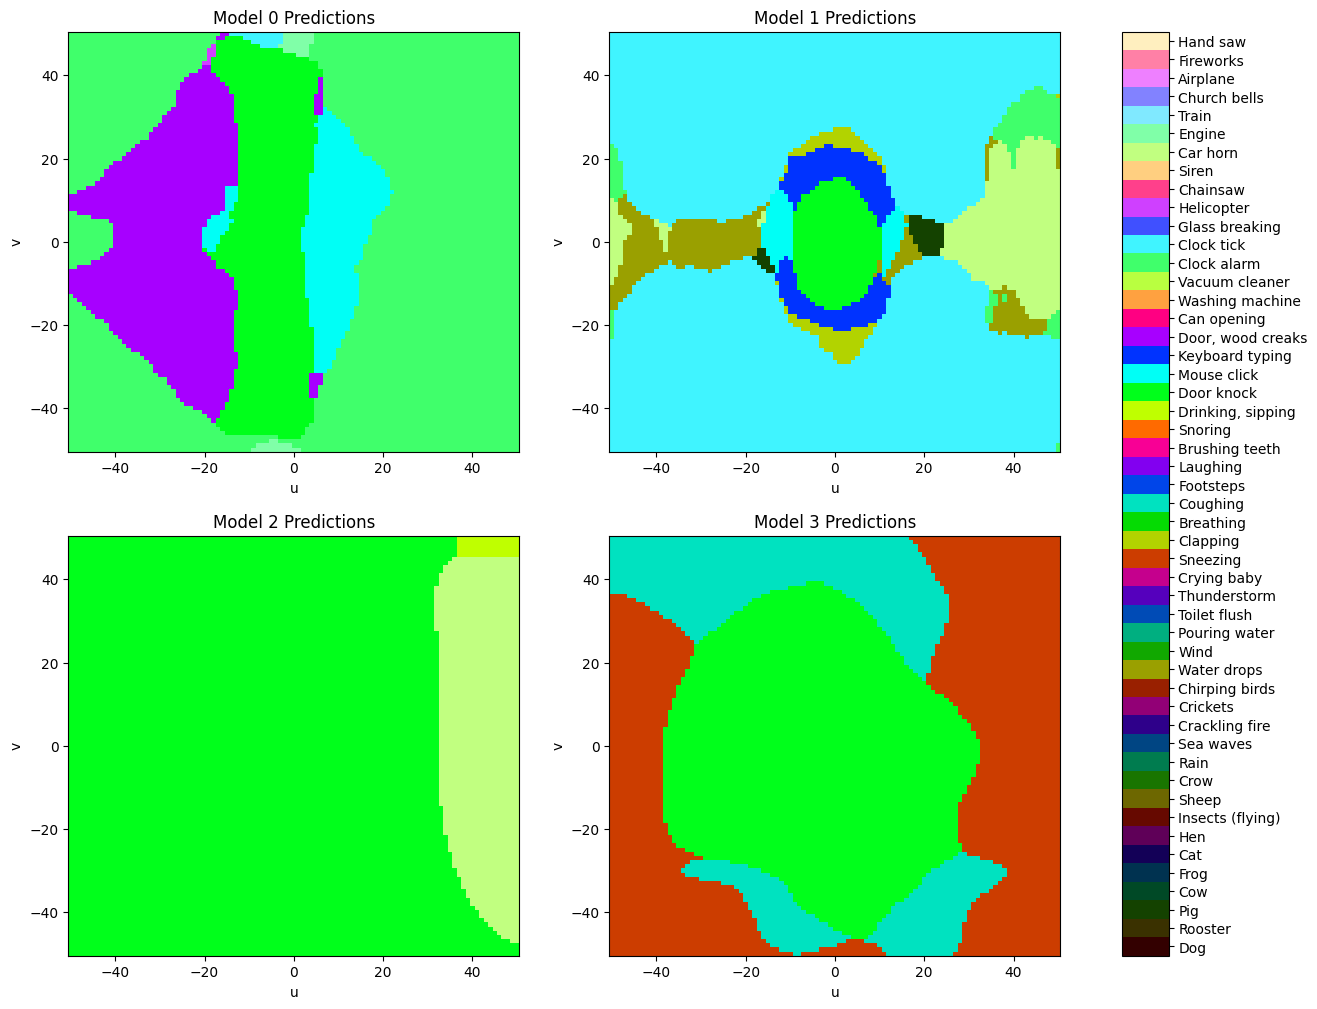

In [41]:
models = [resnet18.to(device), resnet50.to(device), vit_base.to(device), mixer.to(device)]
plot_dec(resnet18.to(device), esc[2][0], esc[2][1], models, 50, categories)

In [40]:
models = [resnet18.to(device), resnet50.to(device), vit_base.to(device), mixer.to(device)]

i=2
x = esc[i][0]
x = x.unsqueeze(0).to(device)
print(esc[i][1])
for model in models:
    model.eval()
    out = model(x)
    print(out.argmax(dim=1).squeeze(0).item())

tensor(30)
30
30
30
30


True:  Snoring


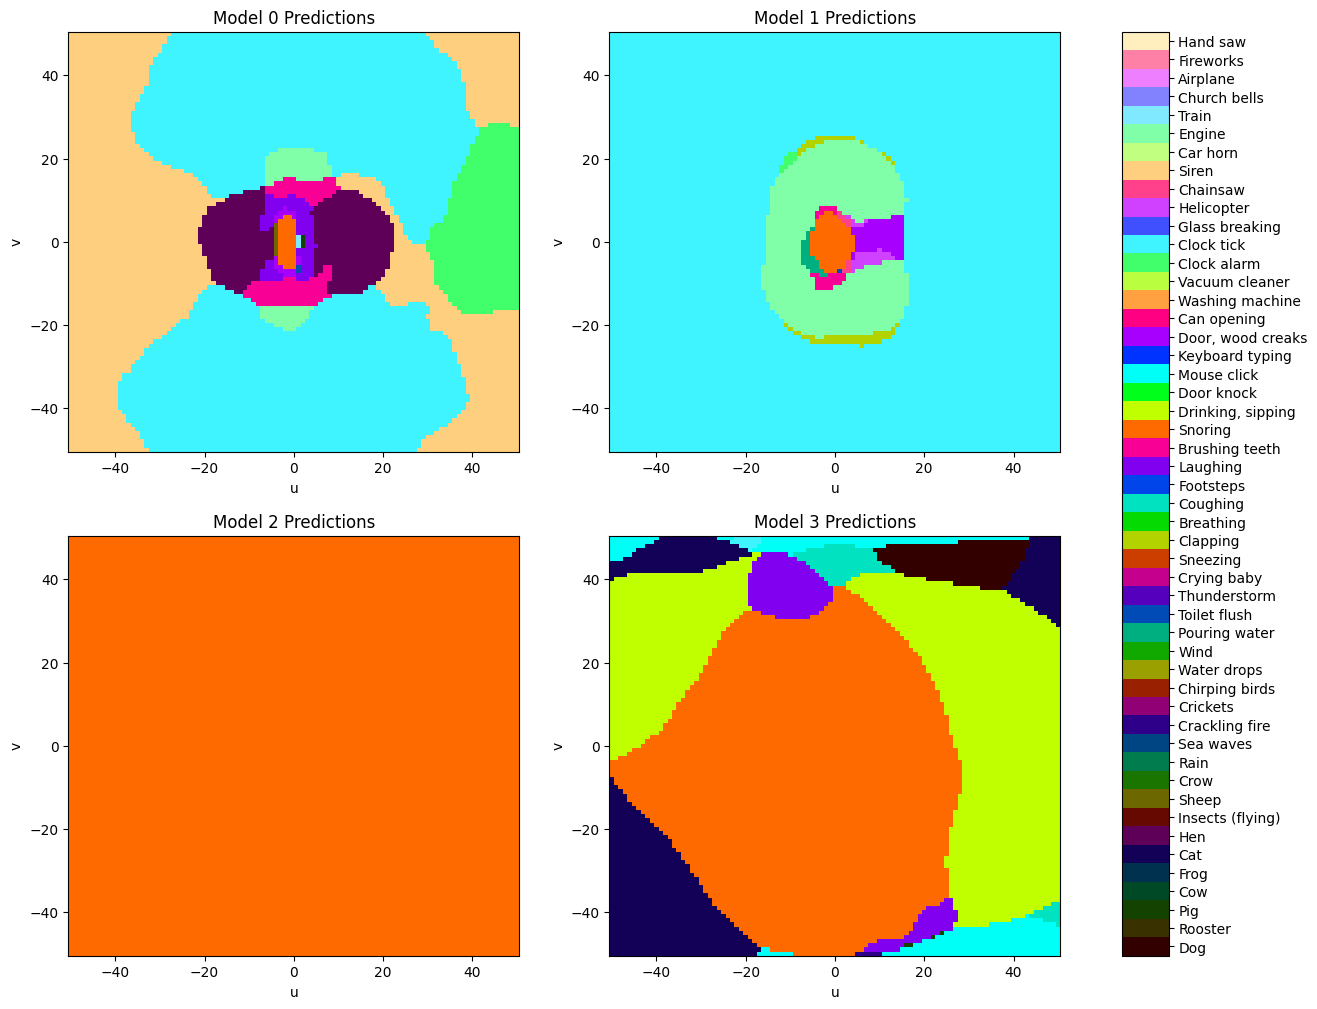

In [44]:
# models = [resnet18.to(device), resnet50.to(device), vit_base.to(device), mixer.to(device)]
plot_dec(resnet18.to(device), esc[10][0], esc[10][1], models, 50, categories)

True:  Breathing


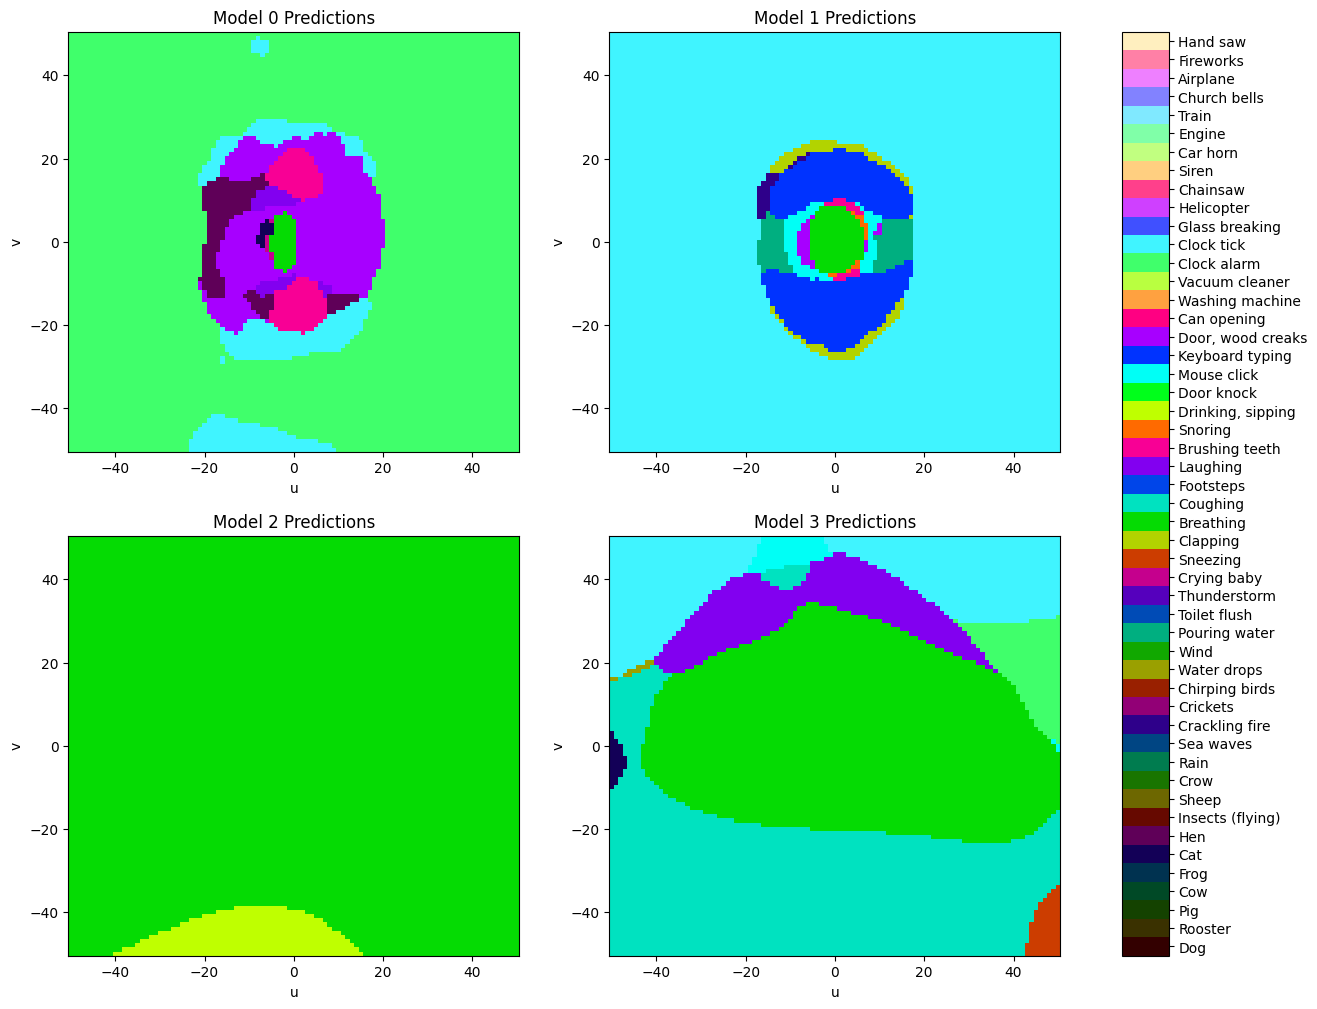

In [43]:
plot_dec(resnet18.to(device), esc[99][0], esc[99][1], models, 50, categories)

# FSC 22

In [29]:
categories_fsc = {
    0: "Fire",
    1: "Rain",
    2: "Thunderstorm",
    3: "WaterDrops",
    4: "Wind",
    5: "Silence",
    6: "TreeFalling",
    7: "Helicopter",
    8: "VehicleEngine",
    9: "Axe",
    10: "Chainsaw",
    11: "Generator",
    12: "Handsaw",
    13: "Firework",
    14: "Gunshot",
    15: "WoodChop",
    16: "Whistling",
    17: "Speaking",
    18: "Footsteps",
    19: "Clapping",
    20: "Insect",
    21: "Frog",
    22: "BirdChirping",
    23: "WingFlaping",
    24: "Lion",
    25: "WolfHowl",
    26: "Squirrel"
}

models = [resnet18.to(device), resnet50.to(device), vit_base.to(device), mixer.to(device)]


In [30]:
i=783
x = fsc[i][0]
x = x.unsqueeze(0).to(device)
print(fsc[i][1])
for model in models:
    model.eval()
    out = model(x)
    print(out.argmax(dim=1).squeeze(0).item())

tensor(22)
22
22
22
22


True:  BirdChirping


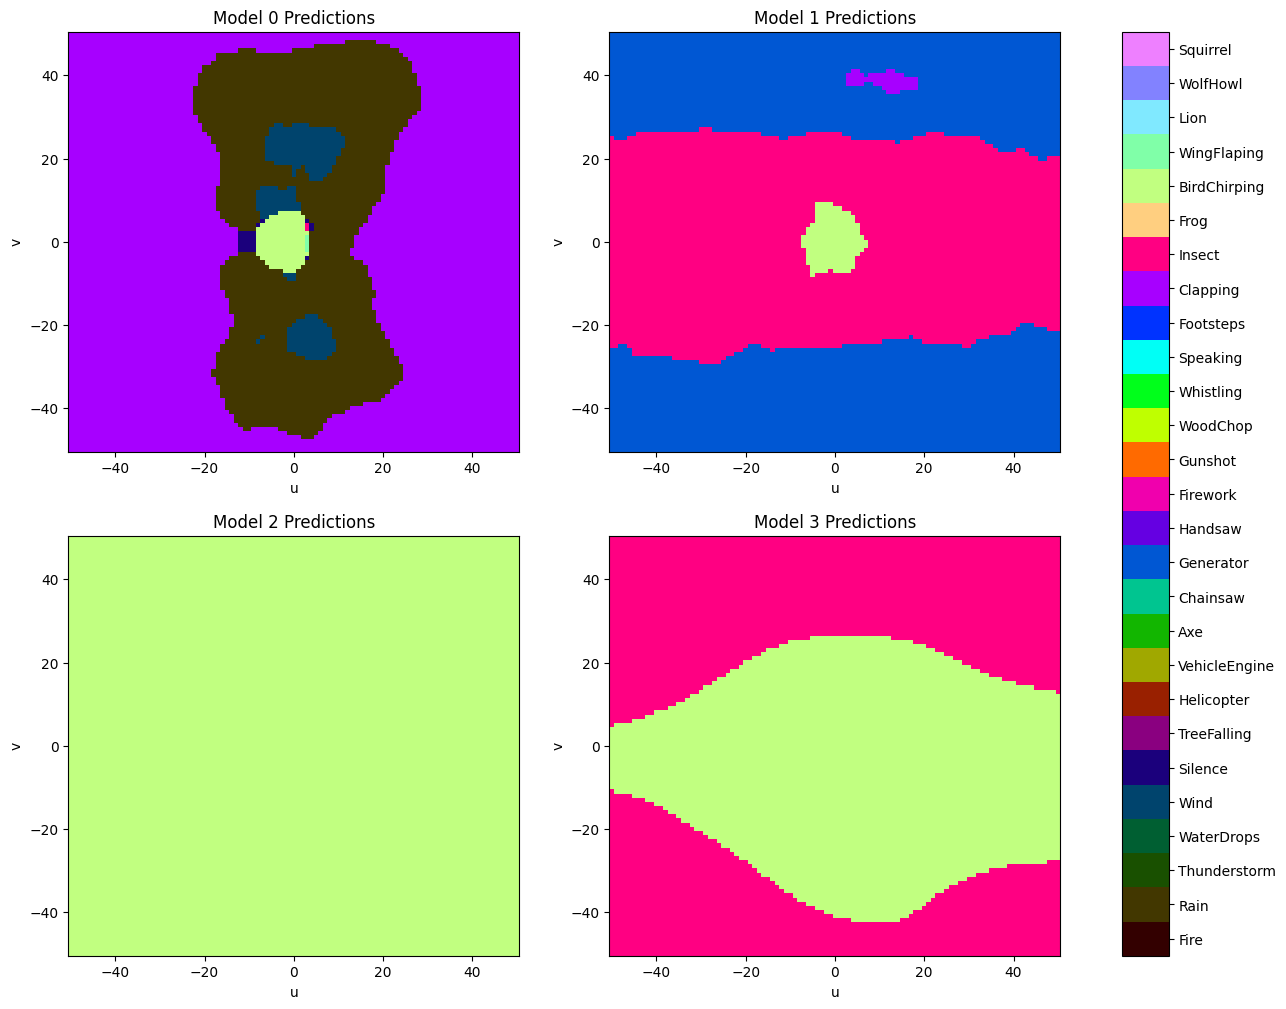

In [31]:
plot_dec(resnet18.to(device), fsc[783][0], fsc[783][1], models, 27, categories_fsc)

True:  Firework


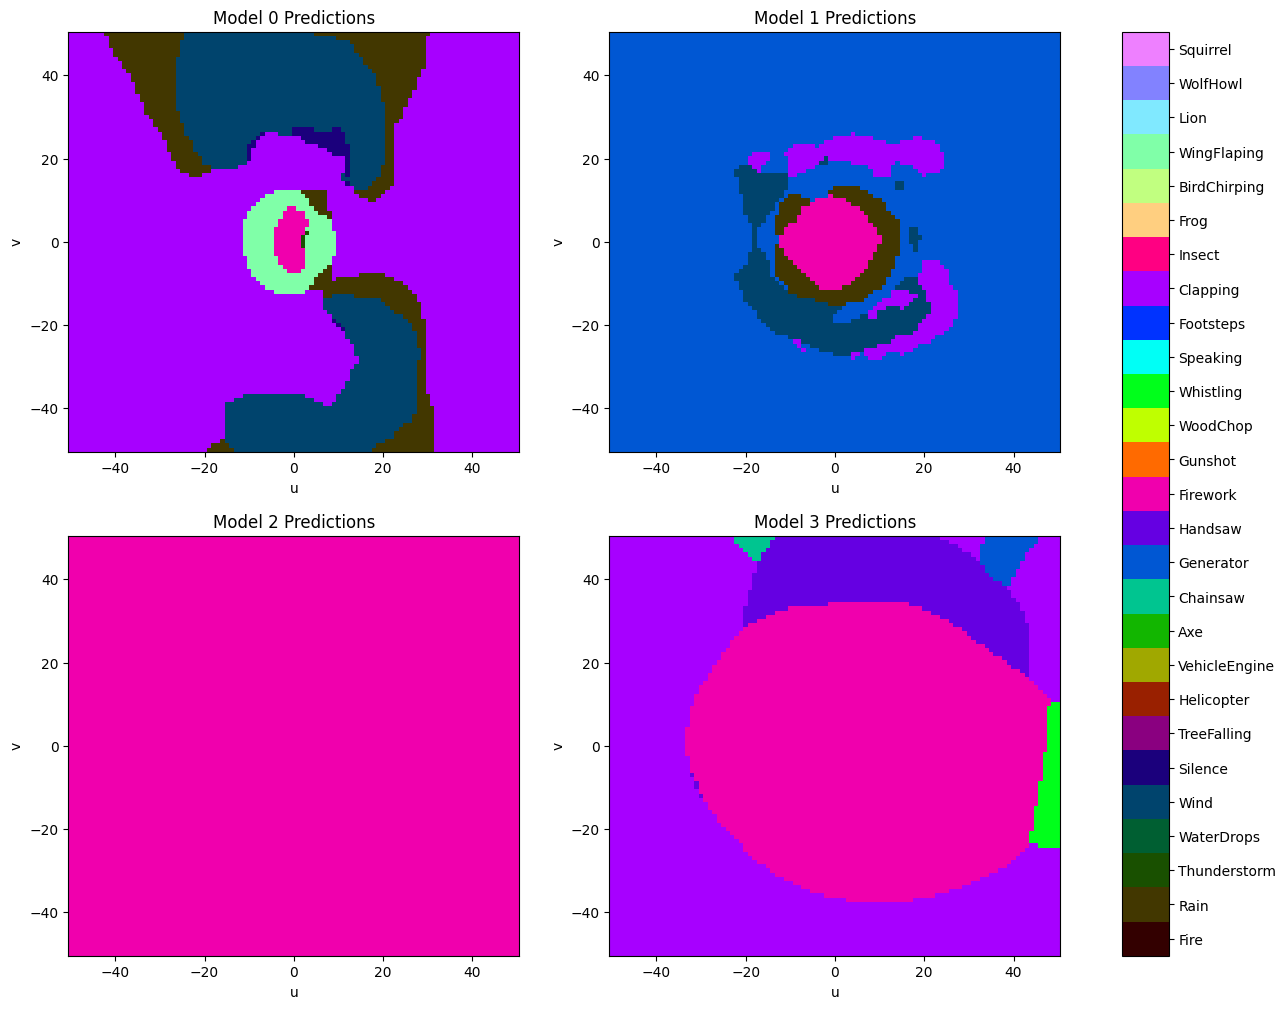

In [32]:
plot_dec(resnet18.to(device), fsc[4][0], fsc[4][1], models, 27, categories_fsc)

# DCASE19

In [18]:
labels = {
    0: 'airport',
    1: 'shopping_mall',
    2: 'metro_station',
    3: 'street_pedestrian',
    4: 'public_square',
    5: 'street_traffic',
    6: 'tram',
    7: 'bus',
    8: 'metro',
    9: 'park'
}

True:  street_pedestrian


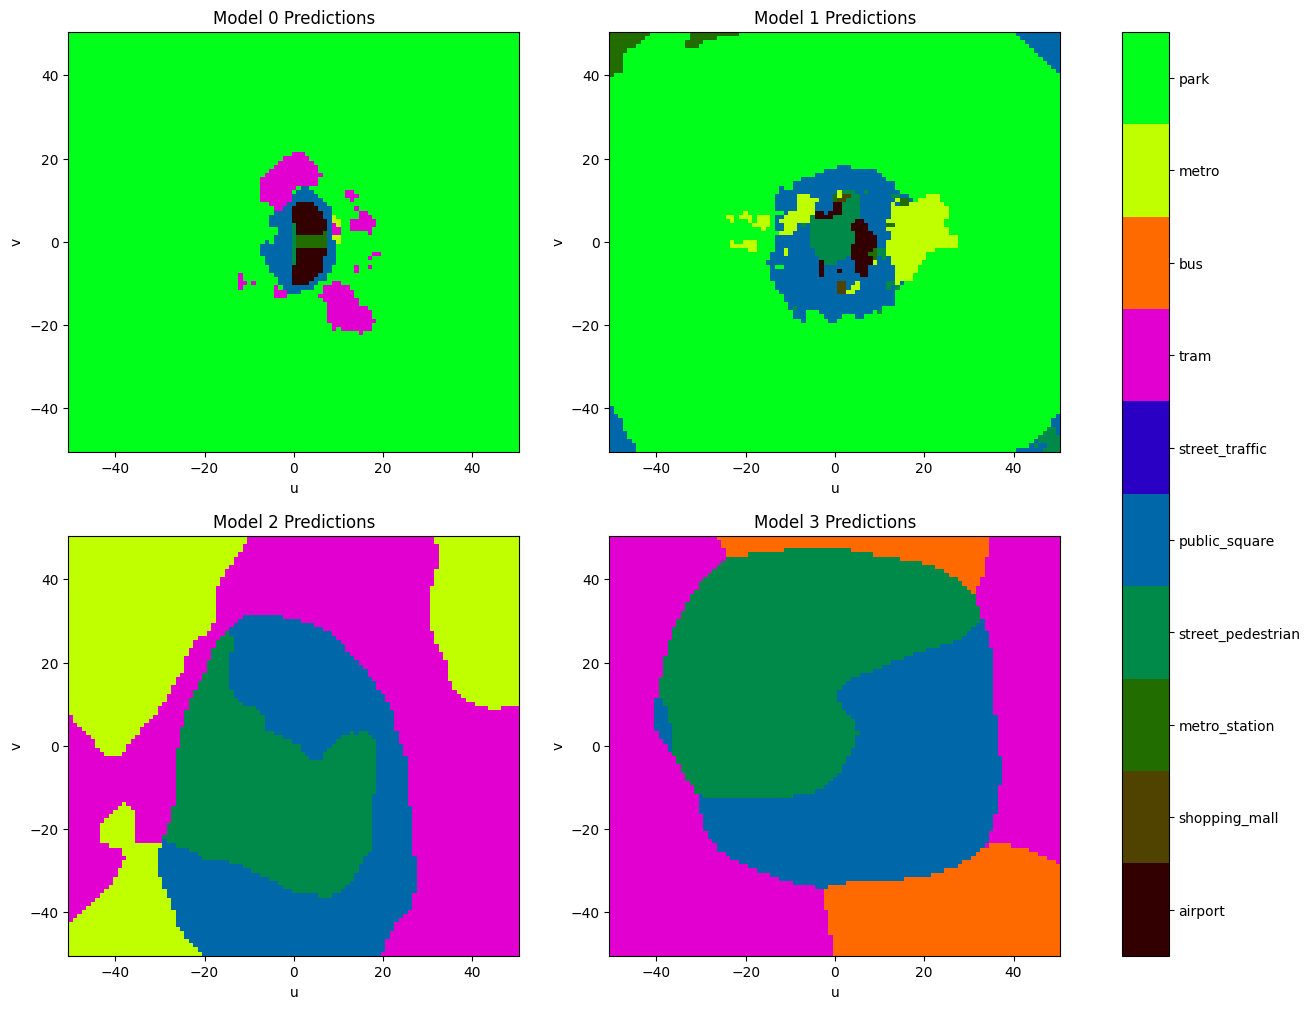

In [23]:
plot_dec(resnet18.to(device), dcase[783][0], dcase[783][1], models, 10, labels)

True:  airport


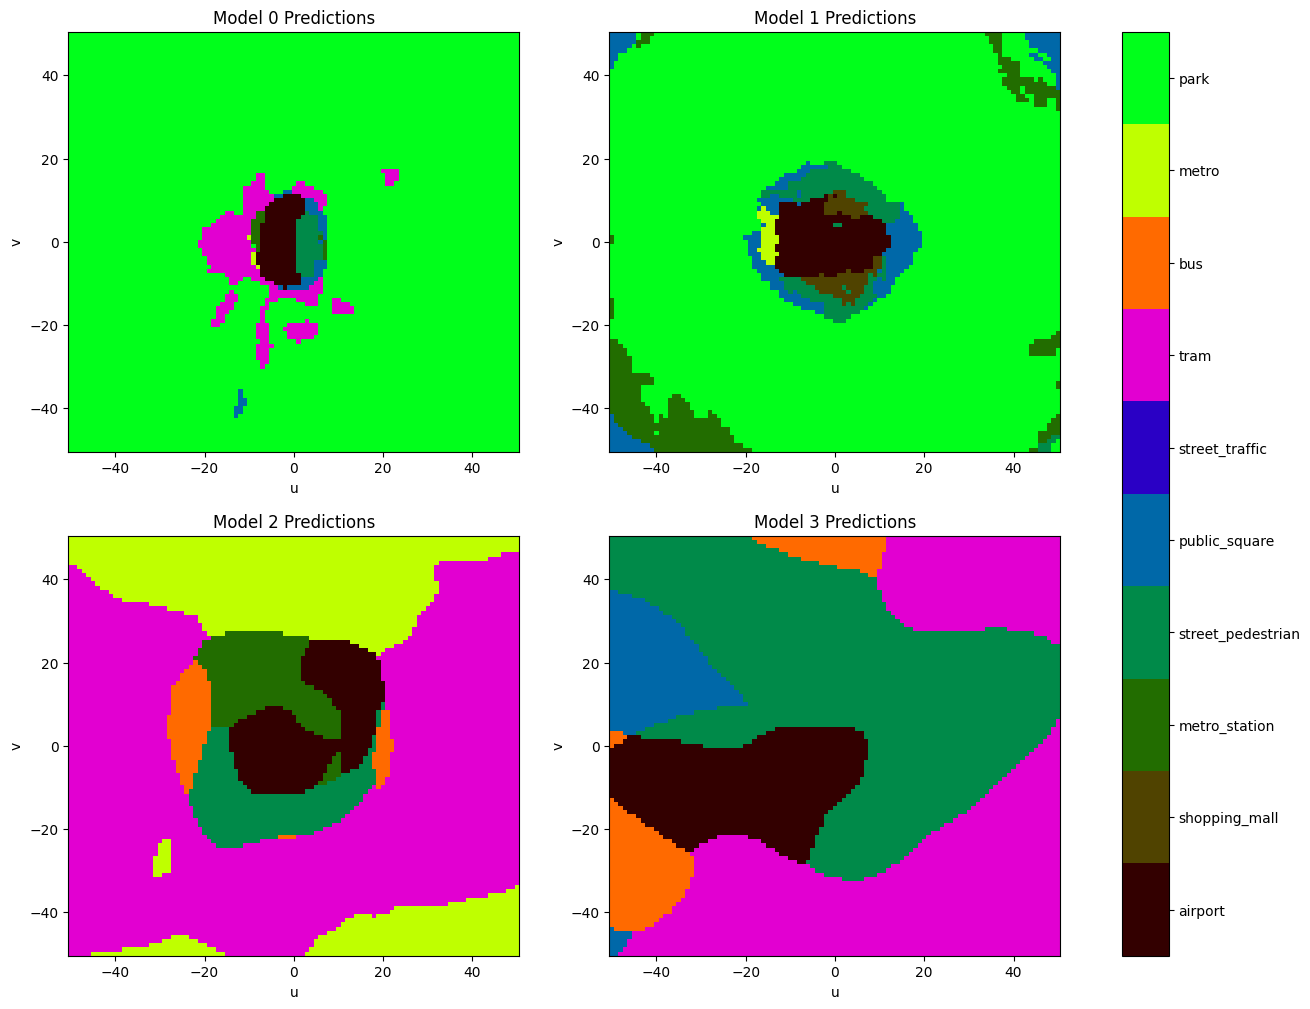

In [22]:
plot_dec(resnet18.to(device), dcase[8372][0], dcase[8372][1], models, 10, labels)

True:  street_traffic


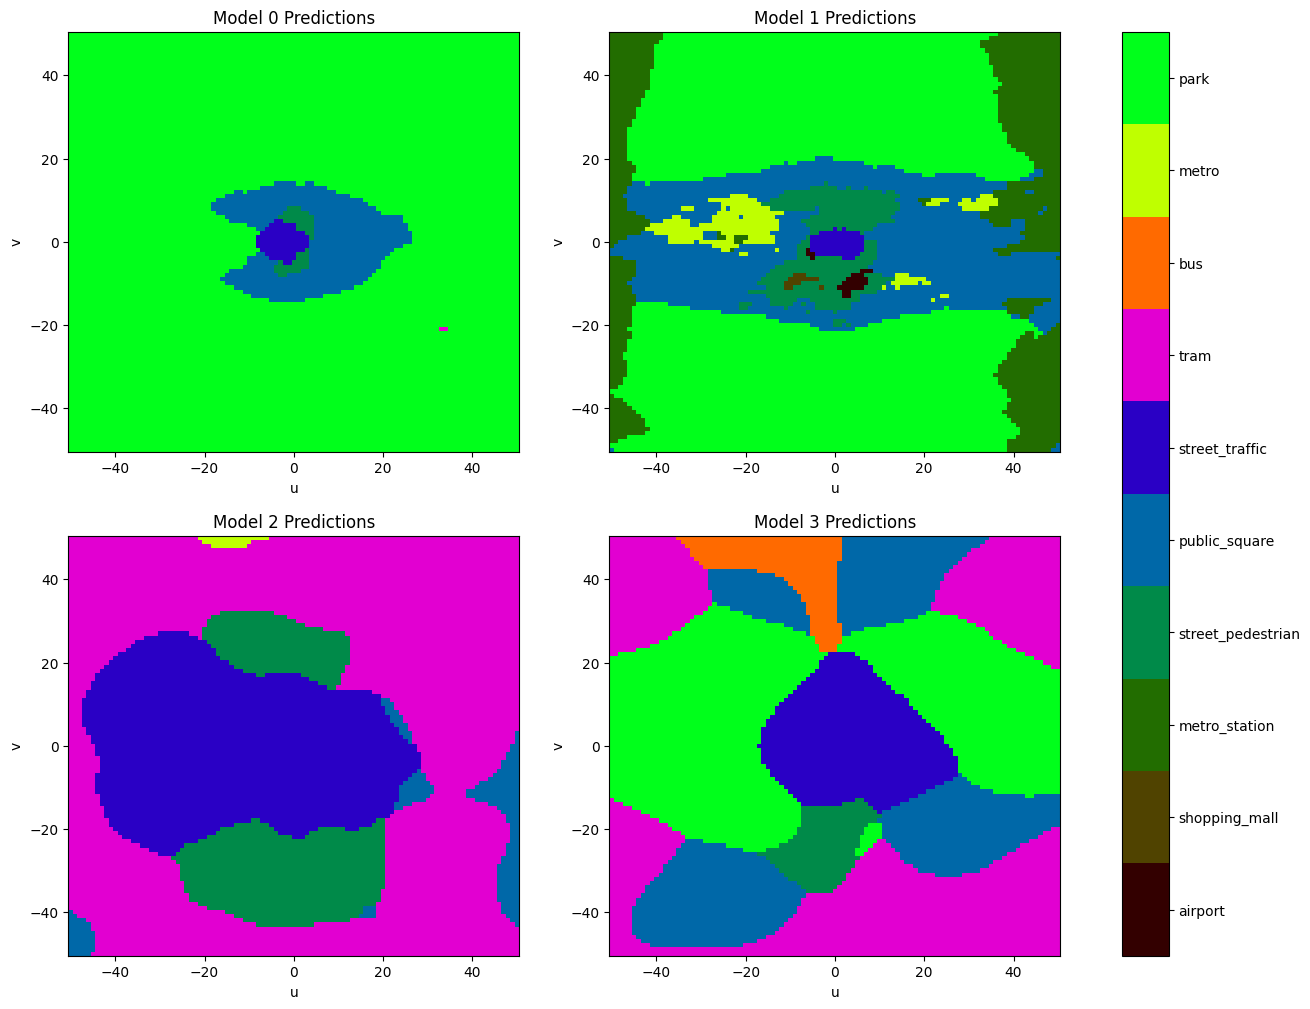

In [21]:
plot_dec(resnet18.to(device), dcase[1482][0], dcase[1482][1], models, 10, labels)